In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data
from torch.utils.data import TensorDataset, DataLoader

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time
import os
import pickle

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
db = "16.2"
features = "polar"
lag = "0"
model_save_dir = os.getcwd() + f"/ml-models/db{db}/{features}-lag{lag}/"

In [4]:
def loadNpy(filename):
    with open(os.getcwd() + "/train-val-test/"+ filename, "rb") as f: return np.load(f)

db = f"db{db}/window-size-10/lag{lag}/{features}-features/"
data_type = ""

In [5]:
DIR = os.getcwd() + "/train-val-test/" + db

In [6]:
def npy_to_tensor(data, l=False):
    if not l:
        data = torch.from_numpy(data).float()
    else:
        data = torch.from_numpy(data).type(torch.LongTensor)
    return data

In [141]:
X_train, X_val, X_test = loadNpy(db + f"X_train.npy"), loadNpy(db + f"X_val.npy"), loadNpy(db + f"X_test.npy")
y_train, y_val, y_test = loadNpy(db + f"y{data_type}_train.npy"), loadNpy(db + f"y{data_type}_val.npy"), loadNpy(db + f"y{data_type}_test.npy")

In [123]:
X_train, X_val, X_test = npy_to_tensor(X_train), npy_to_tensor(X_val), npy_to_tensor(X_test)
y_train, y_val, y_test = npy_to_tensor(y_train, 1), npy_to_tensor(y_val, 1), npy_to_tensor(y_test, 1)

In [7]:
X_train, X_val, X_test = loadNpy(db + f"us-X_train.npy"), loadNpy(db + f"us-X_val.npy"), loadNpy(db + f"us-X_test.npy")
y_train, y_val, y_test = loadNpy(db + f"y{data_type}_train.npy"), loadNpy(db + f"y{data_type}_val.npy"), loadNpy(db + f"y{data_type}_test.npy")

In [8]:
X_train, X_val, X_test = npy_to_tensor(X_train), npy_to_tensor(X_val), npy_to_tensor(X_test)
y_train, y_val, y_test = npy_to_tensor(y_train, 1), npy_to_tensor(y_val, 1), npy_to_tensor(y_test, 1)

In [9]:
batch_size = 128

In [10]:
train_iterator = DataLoader(dataset=TensorDataset(X_train, y_train),batch_size=batch_size,shuffle=False)

val_iterator = DataLoader(dataset=TensorDataset(X_val, y_val), batch_size=batch_size, shuffle=False)

test_iterator = DataLoader(dataset=TensorDataset(X_test, y_test), batch_size=batch_size,shuffle=False)

In [11]:
loaders = {
    "train": train_iterator,
    "val": val_iterator,
    "test": test_iterator
}

In [12]:
torch.save(train_dataset, DIR + "train-dataset")
torch.save(val_dataset, DIR + "val-dataset")
torch.save(test_dataset, DIR + "test-dataset")

NameError: name 'train_dataset' is not defined

In [13]:
X_train.shape

torch.Size([37674, 784])

In [129]:
X_val.shape

torch.Size([12558, 784])

In [218]:
X_test.shape

torch.Size([12594, 784])

In [98]:
input_size = val_iterator

In [99]:
X_train.dtype

torch.float32

In [52]:
np.mean(y_train.numpy())

0.16762223283962413

# Fully Connected NN

In [235]:
input_size = 784
h1_size = 700
h2_size = 800
h3_size = 700
h4_size = 800
h5_size = 700
h6_size = 600
h7_size = 700
h8_size = 600
size = [h1_size, h2_size, h3_size, h4_size, h5_size, h6_size, h7_size, h8_size]*2
num_classes = 2
num_epochs = 2000
batch_size = 64
learning_rate = 0.001

In [236]:
len(size)

16

In [237]:
# Fully connected neural network with one hidden layer
class NeuralNet(nn.Module):
    def __init__(self, input_size, num_classes):
        super(NeuralNet, self).__init__()
        
        self.layers1 = nn.Sequential(
            nn.Linear(input_size, h1_size),
            nn.ReLU(),
            nn.Linear(h1_size, h2_size),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(h2_size, h3_size),
            nn.ReLU(),
            nn.Linear(h3_size, h4_size),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(h4_size, h5_size),
            nn.ReLU(),
            nn.Linear(h5_size, h6_size),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(h6_size, h7_size),
            nn.ReLU(),
            nn.Linear(h7_size, h8_size),
        )
        self.layers2 = nn.Sequential(
            nn.Linear(h8_size, h7_size),
            nn.ReLU(),
            nn.Linear(h7_size, h6_size),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(h6_size, h5_size),
            nn.ReLU(),
            nn.Linear(h5_size, h4_size),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(h4_size, h5_size),
            nn.ReLU(),
            nn.Linear(h5_size, h6_size),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(h6_size, h7_size),
            nn.ReLU(),
            nn.Linear(h7_size, h8_size),
            nn.ReLU(),
            nn.Linear(h8_size, num_classes),
        )
        
        
    
    def forward(self, x):
        out = self.layers1(x)
        out = self.layers2(out)
        return out

In [238]:
nn_model = NeuralNet(input_size, num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nn_model.parameters(), lr=learning_rate, 
                            momentum=0.3)
sched_type = ""

In [239]:
swa_model = torch.optim.swa_utils.AveragedModel(nn_model)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=300)
swa_start = 160
swa_scheduler = optim.swa_utils.SWALR(optimizer, swa_lr=0.05)
sched_type = "swa"

In [240]:
nn_epochs = {}

# Train the model
total_step = len(train_iterator)
for epoch in tqdm(range(num_epochs)):
    nn_epochs[epoch] = {}
    
    for phase in ["train", "val", "test"]:
        total_step = len(loaders[phase].dataset)
        correct = 0
        total = 0
        pred_ys = []
        labs = []

        if phase == "train":
            #optimizer = scheduler(optimizer, epoch)
            nn_model.train(True)
        else:
            nn_model.train(False)
        
        
        for i, (images, labels) in enumerate(loaders[phase]):  
            # Move tensors to the configured device
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            #print(images.shape)
            outputs = nn_model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            
            if phase == "train":
                # backpropagation, compute gradients 
                loss.backward()    
                # apply gradients             
                optimizer.step()
            
            pred_y = torch.max(outputs, 1)[1]#[1].data.squeeze()
            #print(pred_y)
            pred_ys = pred_ys + pred_y.tolist() #test_output.flatten().tolist()
            labs = labs + labels.tolist()
            total += len(labels)
            correct += (pred_y == labels).sum().item()
    
        print ('Phase {} Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(phase, epoch+1, num_epochs, total, total_step, loss.item()))
        print(f'Accuracy of the model on the {total} images: %.3f' % (correct/total))

        cm = np.zeros((2,2))
        for i, p in enumerate(pred_ys):
            label = labs[i]
            cm[label, p] += 1

        print(f"Sensitivity = {cm[1,1]/(cm[1,1] + cm[1,0])}")
        print(f"Specificity = {cm[0,0]/(cm[0,0] + cm[0,1])}")
        print(f"AUC = {roc_auc_score(labs, pred_ys)}")

        nn_epochs[epoch][phase] = {"loss": loss.item(), "acc": correct/total, 
                         "sens": cm[1,1]/(cm[1,1] + cm[1,0]), "spec": cm[0,0]/(cm[0,0] + cm[0,1]),
                        "auc": roc_auc_score(labs, pred_ys)}
    
    print()
    
    if sched_type == "swa":
        if epoch > swa_start:
            swa_model.update_parameters(nn_model)
            swa_scheduler.step()
        else:
            scheduler.step()
    #elif sched_type == "12":         
    #    scheduler1.step()
    #    scheduler2.step()
    #print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
    #       .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
    #nn_epochs[epoch] = {"loss": loss.item(), "train": eval_nn(nn_model, train_iterator), 
    #             "val": eval_nn(nn_model, val_iterator), "test": eval_nn(nn_model, test_iterator)}
    #nn_model.train()

  0%|          | 0/2000 [00:00<?, ?it/s]

Phase train Epoch [1/2000], Step [37674/37674], Loss: 0.6160
Accuracy of the model on the 37674 images: 0.752
Sensitivity = 0.121298495645289
Specificity = 0.8795561082942696
AUC = 0.5004273019697792
Phase val Epoch [1/2000], Step [12558/12558], Loss: 0.6382
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [1/2000], Step [12559/12559], Loss: 0.6113
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [2/2000], Step [37674/37674], Loss: 0.5674
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [2/2000], Step [12558/12558], Loss: 0.6096
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [2/2000], Step [12559/12559], Loss: 0.5589
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [3/200

Phase train Epoch [19/2000], Step [37674/37674], Loss: 0.5262
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [19/2000], Step [12558/12558], Loss: 0.6398
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [19/2000], Step [12559/12559], Loss: 0.5036
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [20/2000], Step [37674/37674], Loss: 0.5263
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [20/2000], Step [12558/12558], Loss: 0.6401
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [20/2000], Step [12559/12559], Loss: 0.5036
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [21/2000], Step [37674/37674], Loss: 0.5266


AUC = 0.5
Phase test Epoch [36/2000], Step [12559/12559], Loss: 0.5039
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [37/2000], Step [37674/37674], Loss: 0.5267
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [37/2000], Step [12558/12558], Loss: 0.6412
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [37/2000], Step [12559/12559], Loss: 0.5039
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [38/2000], Step [37674/37674], Loss: 0.5269
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [38/2000], Step [12558/12558], Loss: 0.6412
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [38/2000], Step [12559/12559], Loss

AUC = 0.5
Phase test Epoch [54/2000], Step [12559/12559], Loss: 0.5040
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [55/2000], Step [37674/37674], Loss: 0.5267
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [55/2000], Step [12558/12558], Loss: 0.6412
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [55/2000], Step [12559/12559], Loss: 0.5040
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [56/2000], Step [37674/37674], Loss: 0.5269
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [56/2000], Step [12558/12558], Loss: 0.6412
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [56/2000], Step [12559/12559], Loss

Phase test Epoch [72/2000], Step [12559/12559], Loss: 0.5040
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [73/2000], Step [37674/37674], Loss: 0.5270
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [73/2000], Step [12558/12558], Loss: 0.6412
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [73/2000], Step [12559/12559], Loss: 0.5040
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [74/2000], Step [37674/37674], Loss: 0.5268
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [74/2000], Step [12558/12558], Loss: 0.6412
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [74/2000], Step [12559/12559], Loss: 0.5040
A

AUC = 0.5
Phase test Epoch [90/2000], Step [12559/12559], Loss: 0.5040
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [91/2000], Step [37674/37674], Loss: 0.5267
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [91/2000], Step [12558/12558], Loss: 0.6412
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [91/2000], Step [12559/12559], Loss: 0.5040
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [92/2000], Step [37674/37674], Loss: 0.5268
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [92/2000], Step [12558/12558], Loss: 0.6412
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [92/2000], Step [12559/12559], Loss

AUC = 0.5
Phase test Epoch [108/2000], Step [12559/12559], Loss: 0.5040
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [109/2000], Step [37674/37674], Loss: 0.5267
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [109/2000], Step [12558/12558], Loss: 0.6413
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [109/2000], Step [12559/12559], Loss: 0.5040
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [110/2000], Step [37674/37674], Loss: 0.5265
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [110/2000], Step [12558/12558], Loss: 0.6413
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [110/2000], Step [12559/12559

Phase val Epoch [126/2000], Step [12558/12558], Loss: 0.6413
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [126/2000], Step [12559/12559], Loss: 0.5040
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [127/2000], Step [37674/37674], Loss: 0.5269
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [127/2000], Step [12558/12558], Loss: 0.6413
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [127/2000], Step [12559/12559], Loss: 0.5040
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [128/2000], Step [37674/37674], Loss: 0.5268
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [128/2000], Step [12558/12558], Loss: 0.

Phase train Epoch [144/2000], Step [37674/37674], Loss: 0.5268
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [144/2000], Step [12558/12558], Loss: 0.6413
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [144/2000], Step [12559/12559], Loss: 0.5040
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [145/2000], Step [37674/37674], Loss: 0.5269
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [145/2000], Step [12558/12558], Loss: 0.6413
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [145/2000], Step [12559/12559], Loss: 0.5040
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [146/2000], Step [37674/37674], Loss: 

Phase test Epoch [161/2000], Step [12559/12559], Loss: 0.5040
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [162/2000], Step [37674/37674], Loss: 0.5269
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [162/2000], Step [12558/12558], Loss: 0.6413
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [162/2000], Step [12559/12559], Loss: 0.5040
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [163/2000], Step [37674/37674], Loss: 0.5270
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [163/2000], Step [12558/12558], Loss: 0.6412
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [163/2000], Step [12559/12559], Loss: 0

Phase test Epoch [179/2000], Step [12559/12559], Loss: 0.5032
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [180/2000], Step [37674/37674], Loss: 0.5262
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [180/2000], Step [12558/12558], Loss: 0.6383
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [180/2000], Step [12559/12559], Loss: 0.5032
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [181/2000], Step [37674/37674], Loss: 0.5261
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [181/2000], Step [12558/12558], Loss: 0.6383
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [181/2000], Step [12559/12559], Loss: 0

AUC = 0.5
Phase test Epoch [197/2000], Step [12559/12559], Loss: 0.5032
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [198/2000], Step [37674/37674], Loss: 0.5262
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [198/2000], Step [12558/12558], Loss: 0.6383
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [198/2000], Step [12559/12559], Loss: 0.5032
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [199/2000], Step [37674/37674], Loss: 0.5262
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [199/2000], Step [12558/12558], Loss: 0.6383
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [199/2000], Step [12559/12559

AUC = 0.5
Phase test Epoch [215/2000], Step [12559/12559], Loss: 0.5032
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [216/2000], Step [37674/37674], Loss: 0.5261
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [216/2000], Step [12558/12558], Loss: 0.6383
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [216/2000], Step [12559/12559], Loss: 0.5032
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [217/2000], Step [37674/37674], Loss: 0.5263
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [217/2000], Step [12558/12558], Loss: 0.6383
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [217/2000], Step [12559/12559

AUC = 0.5
Phase test Epoch [233/2000], Step [12559/12559], Loss: 0.5032
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [234/2000], Step [37674/37674], Loss: 0.5261
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [234/2000], Step [12558/12558], Loss: 0.6383
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [234/2000], Step [12559/12559], Loss: 0.5032
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [235/2000], Step [37674/37674], Loss: 0.5262
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [235/2000], Step [12558/12558], Loss: 0.6383
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [235/2000], Step [12559/12559

AUC = 0.5
Phase test Epoch [251/2000], Step [12559/12559], Loss: 0.5032
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [252/2000], Step [37674/37674], Loss: 0.5261
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [252/2000], Step [12558/12558], Loss: 0.6383
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [252/2000], Step [12559/12559], Loss: 0.5032
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [253/2000], Step [37674/37674], Loss: 0.5261
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [253/2000], Step [12558/12558], Loss: 0.6383
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [253/2000], Step [12559/12559

Phase val Epoch [269/2000], Step [12558/12558], Loss: 0.6383
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [269/2000], Step [12559/12559], Loss: 0.5032
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [270/2000], Step [37674/37674], Loss: 0.5261
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [270/2000], Step [12558/12558], Loss: 0.6383
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [270/2000], Step [12559/12559], Loss: 0.5032
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [271/2000], Step [37674/37674], Loss: 0.5261
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [271/2000], Step [12558/12558], Loss: 0.

Phase train Epoch [287/2000], Step [37674/37674], Loss: 0.5261
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [287/2000], Step [12558/12558], Loss: 0.6383
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [287/2000], Step [12559/12559], Loss: 0.5032
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [288/2000], Step [37674/37674], Loss: 0.5261
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [288/2000], Step [12558/12558], Loss: 0.6383
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [288/2000], Step [12559/12559], Loss: 0.5032
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [289/2000], Step [37674/37674], Loss: 

AUC = 0.5
Phase test Epoch [304/2000], Step [12559/12559], Loss: 0.5032
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [305/2000], Step [37674/37674], Loss: 0.5260
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [305/2000], Step [12558/12558], Loss: 0.6383
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [305/2000], Step [12559/12559], Loss: 0.5032
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [306/2000], Step [37674/37674], Loss: 0.5262
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [306/2000], Step [12558/12558], Loss: 0.6383
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [306/2000], Step [12559/12559

AUC = 0.5
Phase test Epoch [322/2000], Step [12559/12559], Loss: 0.5032
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [323/2000], Step [37674/37674], Loss: 0.5261
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [323/2000], Step [12558/12558], Loss: 0.6384
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [323/2000], Step [12559/12559], Loss: 0.5032
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [324/2000], Step [37674/37674], Loss: 0.5261
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [324/2000], Step [12558/12558], Loss: 0.6384
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [324/2000], Step [12559/12559

AUC = 0.5
Phase test Epoch [340/2000], Step [12559/12559], Loss: 0.5032
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [341/2000], Step [37674/37674], Loss: 0.5260
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [341/2000], Step [12558/12558], Loss: 0.6384
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [341/2000], Step [12559/12559], Loss: 0.5032
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [342/2000], Step [37674/37674], Loss: 0.5261
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [342/2000], Step [12558/12558], Loss: 0.6384
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [342/2000], Step [12559/12559

AUC = 0.5
Phase test Epoch [358/2000], Step [12559/12559], Loss: 0.5032
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [359/2000], Step [37674/37674], Loss: 0.5261
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [359/2000], Step [12558/12558], Loss: 0.6384
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [359/2000], Step [12559/12559], Loss: 0.5032
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [360/2000], Step [37674/37674], Loss: 0.5262
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [360/2000], Step [12558/12558], Loss: 0.6384
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [360/2000], Step [12559/12559

AUC = 0.5
Phase test Epoch [376/2000], Step [12559/12559], Loss: 0.5032
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [377/2000], Step [37674/37674], Loss: 0.5261
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [377/2000], Step [12558/12558], Loss: 0.6384
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [377/2000], Step [12559/12559], Loss: 0.5032
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [378/2000], Step [37674/37674], Loss: 0.5261
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [378/2000], Step [12558/12558], Loss: 0.6384
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [378/2000], Step [12559/12559

Phase test Epoch [394/2000], Step [12559/12559], Loss: 0.5032
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [395/2000], Step [37674/37674], Loss: 0.5261
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [395/2000], Step [12558/12558], Loss: 0.6384
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [395/2000], Step [12559/12559], Loss: 0.5032
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [396/2000], Step [37674/37674], Loss: 0.5262
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [396/2000], Step [12558/12558], Loss: 0.6384
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [396/2000], Step [12559/12559], Loss: 0

AUC = 0.5
Phase test Epoch [412/2000], Step [12559/12559], Loss: 0.5032
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [413/2000], Step [37674/37674], Loss: 0.5261
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [413/2000], Step [12558/12558], Loss: 0.6384
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [413/2000], Step [12559/12559], Loss: 0.5032
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [414/2000], Step [37674/37674], Loss: 0.5261
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [414/2000], Step [12558/12558], Loss: 0.6384
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [414/2000], Step [12559/12559

AUC = 0.5
Phase test Epoch [430/2000], Step [12559/12559], Loss: 0.5032
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [431/2000], Step [37674/37674], Loss: 0.5261
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [431/2000], Step [12558/12558], Loss: 0.6384
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [431/2000], Step [12559/12559], Loss: 0.5032
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [432/2000], Step [37674/37674], Loss: 0.5261
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [432/2000], Step [12558/12558], Loss: 0.6384
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [432/2000], Step [12559/12559

Phase val Epoch [448/2000], Step [12558/12558], Loss: 0.6384
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [448/2000], Step [12559/12559], Loss: 0.5032
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [449/2000], Step [37674/37674], Loss: 0.5261
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [449/2000], Step [12558/12558], Loss: 0.6384
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [449/2000], Step [12559/12559], Loss: 0.5032
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [450/2000], Step [37674/37674], Loss: 0.5262
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [450/2000], Step [12558/12558], Loss: 0.

Phase train Epoch [466/2000], Step [37674/37674], Loss: 0.5261
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [466/2000], Step [12558/12558], Loss: 0.6384
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [466/2000], Step [12559/12559], Loss: 0.5032
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [467/2000], Step [37674/37674], Loss: 0.5261
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [467/2000], Step [12558/12558], Loss: 0.6384
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [467/2000], Step [12559/12559], Loss: 0.5032
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [468/2000], Step [37674/37674], Loss: 

AUC = 0.5
Phase test Epoch [483/2000], Step [12559/12559], Loss: 0.5032
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [484/2000], Step [37674/37674], Loss: 0.5261
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [484/2000], Step [12558/12558], Loss: 0.6384
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [484/2000], Step [12559/12559], Loss: 0.5032
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [485/2000], Step [37674/37674], Loss: 0.5262
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [485/2000], Step [12558/12558], Loss: 0.6384
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [485/2000], Step [12559/12559

Phase test Epoch [501/2000], Step [12559/12559], Loss: 0.5032
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [502/2000], Step [37674/37674], Loss: 0.5261
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [502/2000], Step [12558/12558], Loss: 0.6384
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [502/2000], Step [12559/12559], Loss: 0.5032
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [503/2000], Step [37674/37674], Loss: 0.5261
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [503/2000], Step [12558/12558], Loss: 0.6385
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [503/2000], Step [12559/12559], Loss: 0

Phase test Epoch [519/2000], Step [12559/12559], Loss: 0.5032
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [520/2000], Step [37674/37674], Loss: 0.5261
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [520/2000], Step [12558/12558], Loss: 0.6385
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [520/2000], Step [12559/12559], Loss: 0.5032
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [521/2000], Step [37674/37674], Loss: 0.5260
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [521/2000], Step [12558/12558], Loss: 0.6385
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [521/2000], Step [12559/12559], Loss: 0

Phase test Epoch [537/2000], Step [12559/12559], Loss: 0.5032
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [538/2000], Step [37674/37674], Loss: 0.5261
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [538/2000], Step [12558/12558], Loss: 0.6385
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [538/2000], Step [12559/12559], Loss: 0.5032
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [539/2000], Step [37674/37674], Loss: 0.5261
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [539/2000], Step [12558/12558], Loss: 0.6385
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [539/2000], Step [12559/12559], Loss: 0

AUC = 0.5
Phase test Epoch [555/2000], Step [12559/12559], Loss: 0.5032
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [556/2000], Step [37674/37674], Loss: 0.5261
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [556/2000], Step [12558/12558], Loss: 0.6385
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [556/2000], Step [12559/12559], Loss: 0.5032
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [557/2000], Step [37674/37674], Loss: 0.5261
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [557/2000], Step [12558/12558], Loss: 0.6385
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [557/2000], Step [12559/12559

Phase test Epoch [573/2000], Step [12559/12559], Loss: 0.5032
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [574/2000], Step [37674/37674], Loss: 0.5261
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [574/2000], Step [12558/12558], Loss: 0.6385
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [574/2000], Step [12559/12559], Loss: 0.5032
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [575/2000], Step [37674/37674], Loss: 0.5261
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [575/2000], Step [12558/12558], Loss: 0.6385
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [575/2000], Step [12559/12559], Loss: 0

AUC = 0.5
Phase test Epoch [591/2000], Step [12559/12559], Loss: 0.5032
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [592/2000], Step [37674/37674], Loss: 0.5261
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [592/2000], Step [12558/12558], Loss: 0.6385
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [592/2000], Step [12559/12559], Loss: 0.5032
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [593/2000], Step [37674/37674], Loss: 0.5261
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [593/2000], Step [12558/12558], Loss: 0.6385
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [593/2000], Step [12559/12559

Phase test Epoch [609/2000], Step [12559/12559], Loss: 0.5032
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [610/2000], Step [37674/37674], Loss: 0.5261
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [610/2000], Step [12558/12558], Loss: 0.6385
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [610/2000], Step [12559/12559], Loss: 0.5032
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [611/2000], Step [37674/37674], Loss: 0.5261
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [611/2000], Step [12558/12558], Loss: 0.6385
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [611/2000], Step [12559/12559], Loss: 0

Phase val Epoch [627/2000], Step [12558/12558], Loss: 0.6385
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [627/2000], Step [12559/12559], Loss: 0.5032
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [628/2000], Step [37674/37674], Loss: 0.5261
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [628/2000], Step [12558/12558], Loss: 0.6385
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [628/2000], Step [12559/12559], Loss: 0.5032
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [629/2000], Step [37674/37674], Loss: 0.5261
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [629/2000], Step [12558/12558], Loss: 0.

Phase train Epoch [645/2000], Step [37674/37674], Loss: 0.5261
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [645/2000], Step [12558/12558], Loss: 0.6385
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [645/2000], Step [12559/12559], Loss: 0.5032
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [646/2000], Step [37674/37674], Loss: 0.5261
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [646/2000], Step [12558/12558], Loss: 0.6385
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [646/2000], Step [12559/12559], Loss: 0.5032
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [647/2000], Step [37674/37674], Loss: 

AUC = 0.5
Phase test Epoch [662/2000], Step [12559/12559], Loss: 0.5032
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [663/2000], Step [37674/37674], Loss: 0.5261
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [663/2000], Step [12558/12558], Loss: 0.6385
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [663/2000], Step [12559/12559], Loss: 0.5032
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [664/2000], Step [37674/37674], Loss: 0.5261
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [664/2000], Step [12558/12558], Loss: 0.6385
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [664/2000], Step [12559/12559

AUC = 0.5
Phase test Epoch [680/2000], Step [12559/12559], Loss: 0.5032
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [681/2000], Step [37674/37674], Loss: 0.5261
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [681/2000], Step [12558/12558], Loss: 0.6385
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [681/2000], Step [12559/12559], Loss: 0.5032
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [682/2000], Step [37674/37674], Loss: 0.5261
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [682/2000], Step [12558/12558], Loss: 0.6385
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [682/2000], Step [12559/12559

AUC = 0.5
Phase test Epoch [698/2000], Step [12559/12559], Loss: 0.5032
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [699/2000], Step [37674/37674], Loss: 0.5261
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [699/2000], Step [12558/12558], Loss: 0.6386
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [699/2000], Step [12559/12559], Loss: 0.5032
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [700/2000], Step [37674/37674], Loss: 0.5261
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [700/2000], Step [12558/12558], Loss: 0.6386
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [700/2000], Step [12559/12559

AUC = 0.5
Phase test Epoch [716/2000], Step [12559/12559], Loss: 0.5032
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [717/2000], Step [37674/37674], Loss: 0.5261
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [717/2000], Step [12558/12558], Loss: 0.6386
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [717/2000], Step [12559/12559], Loss: 0.5032
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [718/2000], Step [37674/37674], Loss: 0.5261
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [718/2000], Step [12558/12558], Loss: 0.6386
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [718/2000], Step [12559/12559

AUC = 0.5
Phase test Epoch [734/2000], Step [12559/12559], Loss: 0.5033
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [735/2000], Step [37674/37674], Loss: 0.5261
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [735/2000], Step [12558/12558], Loss: 0.6386
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [735/2000], Step [12559/12559], Loss: 0.5033
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [736/2000], Step [37674/37674], Loss: 0.5261
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [736/2000], Step [12558/12558], Loss: 0.6386
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [736/2000], Step [12559/12559

AUC = 0.5
Phase test Epoch [752/2000], Step [12559/12559], Loss: 0.5033
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [753/2000], Step [37674/37674], Loss: 0.5261
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [753/2000], Step [12558/12558], Loss: 0.6386
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [753/2000], Step [12559/12559], Loss: 0.5033
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [754/2000], Step [37674/37674], Loss: 0.5261
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [754/2000], Step [12558/12558], Loss: 0.6386
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [754/2000], Step [12559/12559

Phase val Epoch [770/2000], Step [12558/12558], Loss: 0.6386
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [770/2000], Step [12559/12559], Loss: 0.5033
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [771/2000], Step [37674/37674], Loss: 0.5261
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [771/2000], Step [12558/12558], Loss: 0.6386
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [771/2000], Step [12559/12559], Loss: 0.5033
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [772/2000], Step [37674/37674], Loss: 0.5261
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [772/2000], Step [12558/12558], Loss: 0.

Phase train Epoch [788/2000], Step [37674/37674], Loss: 0.5261
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [788/2000], Step [12558/12558], Loss: 0.6386
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [788/2000], Step [12559/12559], Loss: 0.5033
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [789/2000], Step [37674/37674], Loss: 0.5261
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [789/2000], Step [12558/12558], Loss: 0.6386
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [789/2000], Step [12559/12559], Loss: 0.5033
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [790/2000], Step [37674/37674], Loss: 

Phase train Epoch [806/2000], Step [37674/37674], Loss: 0.5261
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [806/2000], Step [12558/12558], Loss: 0.6386
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [806/2000], Step [12559/12559], Loss: 0.5033
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [807/2000], Step [37674/37674], Loss: 0.5261
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [807/2000], Step [12558/12558], Loss: 0.6386
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [807/2000], Step [12559/12559], Loss: 0.5033
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [808/2000], Step [37674/37674], Loss: 

AUC = 0.5
Phase test Epoch [823/2000], Step [12559/12559], Loss: 0.5033
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [824/2000], Step [37674/37674], Loss: 0.5261
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [824/2000], Step [12558/12558], Loss: 0.6386
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [824/2000], Step [12559/12559], Loss: 0.5033
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [825/2000], Step [37674/37674], Loss: 0.5261
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [825/2000], Step [12558/12558], Loss: 0.6386
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [825/2000], Step [12559/12559

AUC = 0.5
Phase test Epoch [841/2000], Step [12559/12559], Loss: 0.5033
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [842/2000], Step [37674/37674], Loss: 0.5261
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [842/2000], Step [12558/12558], Loss: 0.6386
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [842/2000], Step [12559/12559], Loss: 0.5033
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [843/2000], Step [37674/37674], Loss: 0.5261
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [843/2000], Step [12558/12558], Loss: 0.6386
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [843/2000], Step [12559/12559

Phase val Epoch [859/2000], Step [12558/12558], Loss: 0.6386
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [859/2000], Step [12559/12559], Loss: 0.5033
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [860/2000], Step [37674/37674], Loss: 0.5261
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [860/2000], Step [12558/12558], Loss: 0.6386
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [860/2000], Step [12559/12559], Loss: 0.5033
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [861/2000], Step [37674/37674], Loss: 0.5261
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [861/2000], Step [12558/12558], Loss: 0.

Phase train Epoch [877/2000], Step [37674/37674], Loss: 0.5261
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [877/2000], Step [12558/12558], Loss: 0.6386
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [877/2000], Step [12559/12559], Loss: 0.5033
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [878/2000], Step [37674/37674], Loss: 0.5261
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [878/2000], Step [12558/12558], Loss: 0.6386
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [878/2000], Step [12559/12559], Loss: 0.5033
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [879/2000], Step [37674/37674], Loss: 

Phase train Epoch [895/2000], Step [37674/37674], Loss: 0.5261
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [895/2000], Step [12558/12558], Loss: 0.6386
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [895/2000], Step [12559/12559], Loss: 0.5033
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [896/2000], Step [37674/37674], Loss: 0.5261
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [896/2000], Step [12558/12558], Loss: 0.6386
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [896/2000], Step [12559/12559], Loss: 0.5033
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [897/2000], Step [37674/37674], Loss: 

Phase train Epoch [913/2000], Step [37674/37674], Loss: 0.5261
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [913/2000], Step [12558/12558], Loss: 0.6386
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [913/2000], Step [12559/12559], Loss: 0.5033
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [914/2000], Step [37674/37674], Loss: 0.5261
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [914/2000], Step [12558/12558], Loss: 0.6386
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [914/2000], Step [12559/12559], Loss: 0.5033
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [915/2000], Step [37674/37674], Loss: 

AUC = 0.5
Phase test Epoch [930/2000], Step [12559/12559], Loss: 0.5033
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [931/2000], Step [37674/37674], Loss: 0.5261
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [931/2000], Step [12558/12558], Loss: 0.6386
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [931/2000], Step [12559/12559], Loss: 0.5033
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [932/2000], Step [37674/37674], Loss: 0.5261
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [932/2000], Step [12558/12558], Loss: 0.6386
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [932/2000], Step [12559/12559

AUC = 0.5
Phase test Epoch [948/2000], Step [12559/12559], Loss: 0.5033
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [949/2000], Step [37674/37674], Loss: 0.5261
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [949/2000], Step [12558/12558], Loss: 0.6386
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [949/2000], Step [12559/12559], Loss: 0.5033
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [950/2000], Step [37674/37674], Loss: 0.5261
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [950/2000], Step [12558/12558], Loss: 0.6386
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [950/2000], Step [12559/12559

AUC = 0.5
Phase test Epoch [966/2000], Step [12559/12559], Loss: 0.5033
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [967/2000], Step [37674/37674], Loss: 0.5261
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [967/2000], Step [12558/12558], Loss: 0.6387
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [967/2000], Step [12559/12559], Loss: 0.5033
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [968/2000], Step [37674/37674], Loss: 0.5261
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [968/2000], Step [12558/12558], Loss: 0.6387
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [968/2000], Step [12559/12559

Phase val Epoch [984/2000], Step [12558/12558], Loss: 0.6387
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [984/2000], Step [12559/12559], Loss: 0.5033
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [985/2000], Step [37674/37674], Loss: 0.5261
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [985/2000], Step [12558/12558], Loss: 0.6387
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [985/2000], Step [12559/12559], Loss: 0.5033
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [986/2000], Step [37674/37674], Loss: 0.5261
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [986/2000], Step [12558/12558], Loss: 0.

Phase train Epoch [1002/2000], Step [37674/37674], Loss: 0.5261
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [1002/2000], Step [12558/12558], Loss: 0.6387
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [1002/2000], Step [12559/12559], Loss: 0.5033
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [1003/2000], Step [37674/37674], Loss: 0.5261
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [1003/2000], Step [12558/12558], Loss: 0.6387
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [1003/2000], Step [12559/12559], Loss: 0.5033
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [1004/2000], Step [37674/37674],

AUC = 0.5
Phase test Epoch [1019/2000], Step [12559/12559], Loss: 0.5033
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [1020/2000], Step [37674/37674], Loss: 0.5261
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [1020/2000], Step [12558/12558], Loss: 0.6387
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [1020/2000], Step [12559/12559], Loss: 0.5033
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [1021/2000], Step [37674/37674], Loss: 0.5261
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [1021/2000], Step [12558/12558], Loss: 0.6387
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [1021/2000], Step [1255

Phase train Epoch [1037/2000], Step [37674/37674], Loss: 0.5261
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [1037/2000], Step [12558/12558], Loss: 0.6387
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [1037/2000], Step [12559/12559], Loss: 0.5033
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [1038/2000], Step [37674/37674], Loss: 0.5261
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [1038/2000], Step [12558/12558], Loss: 0.6387
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [1038/2000], Step [12559/12559], Loss: 0.5033
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [1039/2000], Step [37674/37674],

KeyboardInterrupt: 

In [233]:
with open(f"{model_save_dir}nn-SGD-SWA-{size}.pickle", "ab") as f:
    pickle.dump(nn_epochs, f)
    #nn_epochs = pickle.load(f)

In [214]:
def getNNdata(dtyp, epoch_start=0, epoch_end=2000):
    data = {"train": [], "val": [], "test": []}

    for epoch in range(epoch_start, epoch_end):
        for phase in nn_epochs[epoch].keys():
            data[phase] = data[phase] + [nn_epochs[epoch][phase][dtyp]]
            #aucs[phase] = aucs[phase] + [cnn_epochs[epoch][phase]["auc"]]
    return data

Text(0.5, 1, '8 layer NN (polar features, lag 0)\nusing a SWA SGD optimizer')

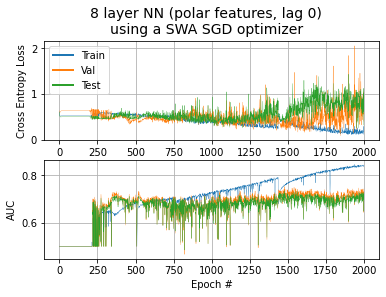

In [234]:
fig, axs = plt.subplots(2)

losses = getNNdata("loss")
aucs = getNNdata("auc")
lw = 0.3

axs[0].plot(np.arange(len(losses["train"])), losses["train"], label="Train", lw=lw)
axs[0].plot(np.arange(len(losses["val"])), losses["val"], label="Val", lw=lw)
axs[0].plot(np.arange(len(losses["test"])), losses["test"], label="Test", lw=lw)
axs[0].set_xlabel("Epoch #")
axs[0].set_ylabel("Cross Entropy Loss")
axs[0].grid(True)
#leg = axs[0].legend(loc="lower left")
#for legobj in leg.legendHandles:
#    legobj.set_linewidth(2.0)
leg = axs[0].legend()
for legobj in leg.legendHandles:
    legobj.set_linewidth(2.0)

axs[1].plot(np.arange(len(aucs["train"])), aucs["train"], label="Train", lw=lw)
axs[1].plot(np.arange(len(aucs["val"])), aucs["val"], label="Val", lw=lw)
axs[1].plot(np.arange(len(aucs["test"])), aucs["test"], label="Test", lw=lw)
axs[1].set_xlabel("Epoch #")
axs[1].set_ylabel("AUC")
axs[1].grid(True)
#axs[1].legend(lw=1)

    
plt.suptitle(f"{len(size)} layer NN ({features} features, lag {lag})\nusing a SWA SGD optimizer",y=1, fontsize=14)

In [ ]:
start = 1000
stop = 1151
step = 50

aucs = getCNNdata("auc", start, stop)

plt.plot(np.arange(len(aucs["train"])), aucs["train"], label="Train")
plt.plot(np.arange(len(aucs["val"])), aucs["val"], label="Val")
plt.plot(np.arange(len(aucs["test"])), aucs["test"], label="Test")
plt.legend(loc="upper left")
plt.xticks(np.arange(0, stop-start, step), np.arange(start, stop, step))
plt.xlabel("Epoch #")
plt.ylabel("AUC")
plt.grid(True)
plt.title("Custom 3D Dual Model using a SWA SGD\nOptimizer for Covid-19 Diagnosis")

In [98]:
def eval_nn(mod, data):
    preds = []
    actual = []
    
    shape = data.dataset.tensors[0].shape[1:]
    
    mod.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in data:
            images = images.to(device)
            labels = labels.to(device)
            outputs = mod(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            preds.append(predicted)
            actual.append(labels)

        print(f'Accuracy of the network on the {total} test images: {100 * correct / total} %')
    return preds, actual, correct/total

In [106]:
train = []
val = []
test = []
loss = []

for i in range(num_epochs):
    ep = nn_epochs[i]
    train.append(ep["train"][2])
    val.append(ep["val"][2])
    test.append(ep["test"][2])
    loss.append(ep["loss"])

ValueError: x and y must have same first dimension, but have shapes (1000,) and (1,)

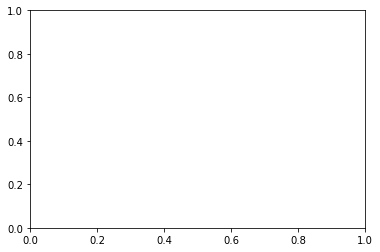

In [252]:
epochs = np.arange(0,num_epochs,1)

plt.plot(epochs, train, c="r", lw=0.7, label="Train")
plt.plot(epochs, val, c="b", lw=0.7, label="Validation")
plt.plot(epochs, test, c="g", lw=0.7, label="Test")
plt.grid(True)
plt.legend(loc="lower right")
plt.title("NN (polar features, lag -300) - Epoch vs. Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch #")
plt.yticks(np.arange(0.83,0.88,0.01))

# CNN

In [28]:
loaders = {
    'train': train_iterator,
    'val': val_iterator,
    'test': test_iterator
}

In [22]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.image = nn.Sequential(
            nn.Conv2d(2, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=2),
            nn.ReLU(inplace=True),
            #nn.MaxPool2d(kernel_size=2, stride=2),
            #nn.Conv2d(32, 64, kernel_size=3, padding=1),
            #nn.ReLU(inplace=True),
            #nn.Conv2d(64, 32, kernel_size=3, padding=1),
            #nn.ReLU(inplace=True),
            #nn.Conv2d(32, 64, kernel_size=3, padding=1),
            #nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 4, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            #nn.MaxPool2d(kernel_size=3, stride=2),
        ).to(device)
        
        self.meta = nn.Sequential(
            nn.Linear(2, 8),
            nn.ReLU(),
            nn.Linear(8, 2),
            nn.ReLU()
            #nn.Dropout(p=0.1),
        ).to(device)
        
        """
        self.combined = nn.Sequential(
            nn.Conv1d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=3, stride=2),
            nn.Conv1d(64, 32, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=3, stride=2),
            nn.Conv1d(32, 2, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            #nn.Conv2d(384, 256, kernel_size=3, padding=1),
            #nn.ReLU(inplace=True),
            #nn.Conv2d(256, 256, kernel_size=3, padding=1),
            #nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=3, stride=2),
        ).to(device)
        
        
        self.image_classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )
        """
        
        # fully connected layer, output 10 classes
        self.out = nn.Sequential(
            #nn.AdaptiveAvgPool1d(2),
            nn.Linear(74, 64),
            nn.ReLU(),
            #nn.BatchNorm1d(512),
            nn.Linear(64, 32),
            nn.ReLU(),
            #nn.BatchNorm1d(128),
            nn.Linear(32, 2),
            nn.ReLU(),
        ).to(device)
        #self.out = nn.Linear(27648, 2).to(device)
        
    def forward(self, x, y):
        #print(x.shape)
        #print(y.shape)
        #print
        #print(x.shape)
        x = self.image(x).reshape(-1, 72) #.flatten()
        #print(x.shape)
        y = self.meta(y).reshape(-1, 2)
        #print(x.shape)
        #print(y.shape)
        z = torch.hstack((x, y)).reshape(-1, 74) #.reshape(1, 32, 281)
        #print(z.shape)
        #print(x.shape)
        #print(y.shape)
        ##print(z.shape)
        output = self.out(z)#.reshape(1,-1)
        return output    # return x for visualization

In [23]:
cnn = CNN()
print(cnn)

CNN(
  (image): Sequential(
    (0): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
  )
  (meta): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=2, bias=True)
    (3): ReLU()
  )
  (out): Sequential(
    (0): Linear(in_features=74, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_feature

In [24]:
loss_func = nn.CrossEntropyLoss()   
loss_func

CrossEntropyLoss()

In [20]:
optimizer = optim.Adam(cnn.parameters(), lr = 0.01)
sched_type = ""
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01
    weight_decay: 0
)

In [25]:
optimizer = optim.SGD(cnn.parameters(), 0.001, momentum=0.4, weight_decay=1e-2)
#optimizer = optim.SGD(cnn.parameters(), 
            #          lr = 0.001, momentum=0.9)#weight_decay=1e-6)
sched_type = ""
optimizer

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.001
    momentum: 0.4
    nesterov: False
    weight_decay: 0.01
)

In [26]:
swa_model = torch.optim.swa_utils.AveragedModel(cnn)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=1000)
swa_start = 100
swa_scheduler = optim.swa_utils.SWALR(optimizer, swa_lr=0.05)
sched_type = "swa"

In [27]:
from torch.autograd import Variable

num_epochs = 1000
cnn_epochs = {}

def train(num_epochs, cnn):
    
    cnn.train()
        
    # Train the model
        
    for epoch in tqdm(range(num_epochs)):
        cnn_epochs[epoch] = {}
        
        for phase in ["train", "val", "test"]:
            total_step = len(loaders[phase].dataset)
            correct = 0
            total = 0
            pred_ys = []
            labs = []
            
            if phase == "train":
                #optimizer = scheduler(optimizer, epoch)
                cnn.train(True)
            else:
                cnn.train(False)
            
            for i, (images, labels) in enumerate(loaders[phase]):
                no_dummy = images[:,:-52]
                meta_data = no_dummy[:,-2:].to(device)
                image_data = no_dummy[:,:-2].reshape(-1,2,5,73).to(device)
                #images = torch.swapaxes(images, 1, 3)

                labels = labels.to(device)
                # gives batch data, normalize x when iterate train_loader
                b_x = Variable(image_data)   # batch x
                b_y = Variable(meta_data)
                b_z = Variable(labels)   # batch y
                
                #print(b_x.shape)
                #print(b_y.shape)
                output = cnn(b_x, b_y)
                #print(output)
                loss = loss_func(output, b_z)

                # clear gradients for this training step   
                optimizer.zero_grad()           

                if phase == "train":
                    # backpropagation, compute gradients 
                    loss.backward()    
                    # apply gradients             
                    optimizer.step()
                    #torch.optim.swa_utils.update_bn(loaders["train"], swa_model)
                #else:
                #    output = swa_model(b_x, b_y)
                #    loss = loss_func(output, b_z)
                #    print(loss)
                
                pred_y = torch.max(output, 1)[1]#[1].data.squeeze()
                #print(pred_y)
                pred_ys = pred_ys + pred_y.tolist() #test_output.flatten().tolist()
                labs = labs + labels.tolist()
                total += len(labels)
                correct += (pred_y == labels).sum().item()
                
            print ('Phase {} Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(phase, epoch+1, num_epochs, total, total_step, loss.item()))
            print(f'Accuracy of the model on the {total} images: %.3f' % (correct/total))

            cm = np.zeros((2,2))
            for i, p in enumerate(pred_ys):
                label = labs[i]
                #print(label)
                #print(p)
                cm[label, p] += 1

            print(f"Sensitivity = {cm[1,1]/(cm[1,1] + cm[1,0])}")
            print(f"Specificity = {cm[0,0]/(cm[0,0] + cm[0,1])}")
            print(f"AUC = {roc_auc_score(labs, pred_ys)}")

            #cnn.train(False)
            #cnn.eval(True)
            cnn_epochs[epoch][phase] = {"loss": loss.item(), "acc": correct/total, 
                                 "sens": cm[1,1]/(cm[1,1] + cm[1,0]), "spec": cm[0,0]/(cm[0,0] + cm[0,1]),
                                "auc": roc_auc_score(labs, pred_ys)}
            #cnn.eval(False)
            #cnn.train(True)
        print()
        
        if sched_type == "swa":
            if epoch > swa_start:
                swa_model.update_parameters(cnn)
                swa_scheduler.step()
            else:
                scheduler.step()
        elif sched_type == "12":         
            scheduler1.step()
            scheduler2.step()
    
        #torch.optim.swa_utils.update_bn(loaders["train"], swa_model)

        #if epoch+1 % 100 == 0:
        #    with open(f"{db}ep{epoch}-3dcnn-6l.pickle", "wb") as f:
        #        pickle.dump(cnn_epochs, f)
    pass

train(num_epochs, cnn)#, X_trval)

  0%|          | 0/1000 [00:00<?, ?it/s]

Phase train Epoch [1/1000], Step [37674/37674], Loss: 0.6137
Accuracy of the model on the 37674 images: 0.797
Sensitivity = 0.059224069675376086
Specificity = 0.9454064223986735
AUC = 0.5023152460370247
Phase val Epoch [1/1000], Step [12558/12558], Loss: 0.6366
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [1/1000], Step [12559/12559], Loss: 0.6089
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [2/1000], Step [37674/37674], Loss: 0.5867
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [2/1000], Step [12558/12558], Loss: 0.6200
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [2/1000], Step [12559/12559], Loss: 0.5799
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [3/

Phase test Epoch [18/1000], Step [12559/12559], Loss: 0.5004
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [19/1000], Step [37674/37674], Loss: 0.5204
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [19/1000], Step [12558/12558], Loss: 0.6207
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [19/1000], Step [12559/12559], Loss: 0.5005
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [20/1000], Step [37674/37674], Loss: 0.5207
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [20/1000], Step [12558/12558], Loss: 0.6221
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [20/1000], Step [12559/12559], Loss: 0.5005
A

Phase test Epoch [36/1000], Step [12559/12559], Loss: 0.5017
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [37/1000], Step [37674/37674], Loss: 0.5234
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [37/1000], Step [12558/12558], Loss: 0.6318
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [37/1000], Step [12559/12559], Loss: 0.5018
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [38/1000], Step [37674/37674], Loss: 0.5234
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [38/1000], Step [12558/12558], Loss: 0.6319
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [38/1000], Step [12559/12559], Loss: 0.5018
A

Phase test Epoch [54/1000], Step [12559/12559], Loss: 0.5020
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [55/1000], Step [37674/37674], Loss: 0.5237
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [55/1000], Step [12558/12558], Loss: 0.6328
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [55/1000], Step [12559/12559], Loss: 0.5020
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [56/1000], Step [37674/37674], Loss: 0.5237
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [56/1000], Step [12558/12558], Loss: 0.6328
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [56/1000], Step [12559/12559], Loss: 0.5020
A

Phase test Epoch [72/1000], Step [12559/12559], Loss: 0.5020
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [73/1000], Step [37674/37674], Loss: 0.5238
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [73/1000], Step [12558/12558], Loss: 0.6329
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [73/1000], Step [12559/12559], Loss: 0.5020
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [74/1000], Step [37674/37674], Loss: 0.5238
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [74/1000], Step [12558/12558], Loss: 0.6329
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [74/1000], Step [12559/12559], Loss: 0.5020
A

Phase test Epoch [90/1000], Step [12559/12559], Loss: 0.5020
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [91/1000], Step [37674/37674], Loss: 0.5238
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [91/1000], Step [12558/12558], Loss: 0.6329
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [91/1000], Step [12559/12559], Loss: 0.5020
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [92/1000], Step [37674/37674], Loss: 0.5238
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [92/1000], Step [12558/12558], Loss: 0.6329
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [92/1000], Step [12559/12559], Loss: 0.5020
A

Phase test Epoch [108/1000], Step [12559/12559], Loss: 0.5016
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [109/1000], Step [37674/37674], Loss: 0.5233
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [109/1000], Step [12558/12558], Loss: 0.6310
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [109/1000], Step [12559/12559], Loss: 0.5016
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [110/1000], Step [37674/37674], Loss: 0.5233
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [110/1000], Step [12558/12558], Loss: 0.6310
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [110/1000], Step [12559/12559], Loss: 0

Phase test Epoch [126/1000], Step [12559/12559], Loss: 0.5016
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [127/1000], Step [37674/37674], Loss: 0.5234
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [127/1000], Step [12558/12558], Loss: 0.6311
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [127/1000], Step [12559/12559], Loss: 0.5016
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [128/1000], Step [37674/37674], Loss: 0.5234
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [128/1000], Step [12558/12558], Loss: 0.6311
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [128/1000], Step [12559/12559], Loss: 0

Phase test Epoch [144/1000], Step [12559/12559], Loss: 0.5016
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [145/1000], Step [37674/37674], Loss: 0.5234
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [145/1000], Step [12558/12558], Loss: 0.6311
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [145/1000], Step [12559/12559], Loss: 0.5016
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [146/1000], Step [37674/37674], Loss: 0.5234
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [146/1000], Step [12558/12558], Loss: 0.6311
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [146/1000], Step [12559/12559], Loss: 0

Phase test Epoch [162/1000], Step [12559/12559], Loss: 0.5016
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [163/1000], Step [37674/37674], Loss: 0.5234
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [163/1000], Step [12558/12558], Loss: 0.6311
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [163/1000], Step [12559/12559], Loss: 0.5016
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [164/1000], Step [37674/37674], Loss: 0.5234
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [164/1000], Step [12558/12558], Loss: 0.6311
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [164/1000], Step [12559/12559], Loss: 0

Phase test Epoch [180/1000], Step [12559/12559], Loss: 0.5016
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [181/1000], Step [37674/37674], Loss: 0.5234
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [181/1000], Step [12558/12558], Loss: 0.6311
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [181/1000], Step [12559/12559], Loss: 0.5016
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [182/1000], Step [37674/37674], Loss: 0.5234
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [182/1000], Step [12558/12558], Loss: 0.6311
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [182/1000], Step [12559/12559], Loss: 0

Phase test Epoch [198/1000], Step [12559/12559], Loss: 0.5016
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [199/1000], Step [37674/37674], Loss: 0.5234
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [199/1000], Step [12558/12558], Loss: 0.6311
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [199/1000], Step [12559/12559], Loss: 0.5016
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [200/1000], Step [37674/37674], Loss: 0.5234
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [200/1000], Step [12558/12558], Loss: 0.6311
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [200/1000], Step [12559/12559], Loss: 0

Phase test Epoch [216/1000], Step [12559/12559], Loss: 0.5016
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [217/1000], Step [37674/37674], Loss: 0.5234
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [217/1000], Step [12558/12558], Loss: 0.6311
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [217/1000], Step [12559/12559], Loss: 0.5016
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [218/1000], Step [37674/37674], Loss: 0.5234
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [218/1000], Step [12558/12558], Loss: 0.6311
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [218/1000], Step [12559/12559], Loss: 0

Phase test Epoch [234/1000], Step [12559/12559], Loss: 0.5016
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [235/1000], Step [37674/37674], Loss: 0.5234
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [235/1000], Step [12558/12558], Loss: 0.6311
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [235/1000], Step [12559/12559], Loss: 0.5016
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [236/1000], Step [37674/37674], Loss: 0.5234
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [236/1000], Step [12558/12558], Loss: 0.6311
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [236/1000], Step [12559/12559], Loss: 0

Phase test Epoch [252/1000], Step [12559/12559], Loss: 0.5016
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [253/1000], Step [37674/37674], Loss: 0.5234
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [253/1000], Step [12558/12558], Loss: 0.6311
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [253/1000], Step [12559/12559], Loss: 0.5016
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [254/1000], Step [37674/37674], Loss: 0.5234
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [254/1000], Step [12558/12558], Loss: 0.6311
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [254/1000], Step [12559/12559], Loss: 0

Phase test Epoch [270/1000], Step [12559/12559], Loss: 0.5016
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [271/1000], Step [37674/37674], Loss: 0.5234
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [271/1000], Step [12558/12558], Loss: 0.6311
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [271/1000], Step [12559/12559], Loss: 0.5016
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [272/1000], Step [37674/37674], Loss: 0.5234
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [272/1000], Step [12558/12558], Loss: 0.6311
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [272/1000], Step [12559/12559], Loss: 0

Phase test Epoch [288/1000], Step [12559/12559], Loss: 0.5016
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [289/1000], Step [37674/37674], Loss: 0.5234
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [289/1000], Step [12558/12558], Loss: 0.6311
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [289/1000], Step [12559/12559], Loss: 0.5016
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [290/1000], Step [37674/37674], Loss: 0.5234
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [290/1000], Step [12558/12558], Loss: 0.6311
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [290/1000], Step [12559/12559], Loss: 0

Phase test Epoch [306/1000], Step [12559/12559], Loss: 0.5016
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [307/1000], Step [37674/37674], Loss: 0.5234
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [307/1000], Step [12558/12558], Loss: 0.6311
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [307/1000], Step [12559/12559], Loss: 0.5016
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [308/1000], Step [37674/37674], Loss: 0.5234
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [308/1000], Step [12558/12558], Loss: 0.6311
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [308/1000], Step [12559/12559], Loss: 0

Phase test Epoch [324/1000], Step [12559/12559], Loss: 0.5016
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [325/1000], Step [37674/37674], Loss: 0.5234
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [325/1000], Step [12558/12558], Loss: 0.6311
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [325/1000], Step [12559/12559], Loss: 0.5016
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [326/1000], Step [37674/37674], Loss: 0.5234
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [326/1000], Step [12558/12558], Loss: 0.6311
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [326/1000], Step [12559/12559], Loss: 0

Phase test Epoch [342/1000], Step [12559/12559], Loss: 0.5016
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [343/1000], Step [37674/37674], Loss: 0.5234
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [343/1000], Step [12558/12558], Loss: 0.6311
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [343/1000], Step [12559/12559], Loss: 0.5016
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [344/1000], Step [37674/37674], Loss: 0.5234
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [344/1000], Step [12558/12558], Loss: 0.6311
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [344/1000], Step [12559/12559], Loss: 0

Phase test Epoch [360/1000], Step [12559/12559], Loss: 0.5016
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [361/1000], Step [37674/37674], Loss: 0.5234
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [361/1000], Step [12558/12558], Loss: 0.6311
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [361/1000], Step [12559/12559], Loss: 0.5016
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [362/1000], Step [37674/37674], Loss: 0.5234
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [362/1000], Step [12558/12558], Loss: 0.6311
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [362/1000], Step [12559/12559], Loss: 0

Phase test Epoch [378/1000], Step [12559/12559], Loss: 0.5016
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [379/1000], Step [37674/37674], Loss: 0.5234
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [379/1000], Step [12558/12558], Loss: 0.6311
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [379/1000], Step [12559/12559], Loss: 0.5016
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [380/1000], Step [37674/37674], Loss: 0.5234
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [380/1000], Step [12558/12558], Loss: 0.6311
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [380/1000], Step [12559/12559], Loss: 0

Phase test Epoch [396/1000], Step [12559/12559], Loss: 0.5016
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [397/1000], Step [37674/37674], Loss: 0.5234
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [397/1000], Step [12558/12558], Loss: 0.6311
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [397/1000], Step [12559/12559], Loss: 0.5016
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [398/1000], Step [37674/37674], Loss: 0.5234
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [398/1000], Step [12558/12558], Loss: 0.6311
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [398/1000], Step [12559/12559], Loss: 0

Phase test Epoch [414/1000], Step [12559/12559], Loss: 0.5016
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [415/1000], Step [37674/37674], Loss: 0.5234
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [415/1000], Step [12558/12558], Loss: 0.6311
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [415/1000], Step [12559/12559], Loss: 0.5016
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [416/1000], Step [37674/37674], Loss: 0.5234
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [416/1000], Step [12558/12558], Loss: 0.6311
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [416/1000], Step [12559/12559], Loss: 0

Phase test Epoch [432/1000], Step [12559/12559], Loss: 0.5016
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [433/1000], Step [37674/37674], Loss: 0.5234
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [433/1000], Step [12558/12558], Loss: 0.6311
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [433/1000], Step [12559/12559], Loss: 0.5016
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [434/1000], Step [37674/37674], Loss: 0.5234
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [434/1000], Step [12558/12558], Loss: 0.6311
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [434/1000], Step [12559/12559], Loss: 0

Phase test Epoch [450/1000], Step [12559/12559], Loss: 0.5016
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [451/1000], Step [37674/37674], Loss: 0.5234
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [451/1000], Step [12558/12558], Loss: 0.6311
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [451/1000], Step [12559/12559], Loss: 0.5016
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [452/1000], Step [37674/37674], Loss: 0.5234
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [452/1000], Step [12558/12558], Loss: 0.6311
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [452/1000], Step [12559/12559], Loss: 0

Phase test Epoch [468/1000], Step [12559/12559], Loss: 0.5016
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [469/1000], Step [37674/37674], Loss: 0.5234
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [469/1000], Step [12558/12558], Loss: 0.6311
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [469/1000], Step [12559/12559], Loss: 0.5016
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [470/1000], Step [37674/37674], Loss: 0.5234
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [470/1000], Step [12558/12558], Loss: 0.6311
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [470/1000], Step [12559/12559], Loss: 0

Phase test Epoch [486/1000], Step [12559/12559], Loss: 0.5016
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [487/1000], Step [37674/37674], Loss: 0.5234
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [487/1000], Step [12558/12558], Loss: 0.6311
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [487/1000], Step [12559/12559], Loss: 0.5016
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [488/1000], Step [37674/37674], Loss: 0.5234
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [488/1000], Step [12558/12558], Loss: 0.6311
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [488/1000], Step [12559/12559], Loss: 0

Phase test Epoch [504/1000], Step [12559/12559], Loss: 0.5016
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [505/1000], Step [37674/37674], Loss: 0.5234
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [505/1000], Step [12558/12558], Loss: 0.6311
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [505/1000], Step [12559/12559], Loss: 0.5016
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [506/1000], Step [37674/37674], Loss: 0.5234
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [506/1000], Step [12558/12558], Loss: 0.6311
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [506/1000], Step [12559/12559], Loss: 0

Phase test Epoch [522/1000], Step [12559/12559], Loss: 0.5016
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [523/1000], Step [37674/37674], Loss: 0.5234
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [523/1000], Step [12558/12558], Loss: 0.6311
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [523/1000], Step [12559/12559], Loss: 0.5016
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [524/1000], Step [37674/37674], Loss: 0.5234
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [524/1000], Step [12558/12558], Loss: 0.6311
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [524/1000], Step [12559/12559], Loss: 0

Phase test Epoch [540/1000], Step [12559/12559], Loss: 0.5016
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [541/1000], Step [37674/37674], Loss: 0.5234
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [541/1000], Step [12558/12558], Loss: 0.6311
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [541/1000], Step [12559/12559], Loss: 0.5016
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [542/1000], Step [37674/37674], Loss: 0.5234
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [542/1000], Step [12558/12558], Loss: 0.6311
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [542/1000], Step [12559/12559], Loss: 0

Phase test Epoch [558/1000], Step [12559/12559], Loss: 0.5016
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [559/1000], Step [37674/37674], Loss: 0.5234
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [559/1000], Step [12558/12558], Loss: 0.6311
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [559/1000], Step [12559/12559], Loss: 0.5016
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [560/1000], Step [37674/37674], Loss: 0.5234
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [560/1000], Step [12558/12558], Loss: 0.6311
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [560/1000], Step [12559/12559], Loss: 0

Phase test Epoch [576/1000], Step [12559/12559], Loss: 0.5016
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [577/1000], Step [37674/37674], Loss: 0.5234
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [577/1000], Step [12558/12558], Loss: 0.6311
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [577/1000], Step [12559/12559], Loss: 0.5016
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [578/1000], Step [37674/37674], Loss: 0.5234
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [578/1000], Step [12558/12558], Loss: 0.6311
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [578/1000], Step [12559/12559], Loss: 0

Phase test Epoch [594/1000], Step [12559/12559], Loss: 0.5016
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [595/1000], Step [37674/37674], Loss: 0.5234
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [595/1000], Step [12558/12558], Loss: 0.6311
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [595/1000], Step [12559/12559], Loss: 0.5016
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [596/1000], Step [37674/37674], Loss: 0.5234
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [596/1000], Step [12558/12558], Loss: 0.6311
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [596/1000], Step [12559/12559], Loss: 0

Phase test Epoch [612/1000], Step [12559/12559], Loss: 0.5016
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [613/1000], Step [37674/37674], Loss: 0.5234
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [613/1000], Step [12558/12558], Loss: 0.6311
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [613/1000], Step [12559/12559], Loss: 0.5016
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [614/1000], Step [37674/37674], Loss: 0.5234
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [614/1000], Step [12558/12558], Loss: 0.6311
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [614/1000], Step [12559/12559], Loss: 0

Phase test Epoch [630/1000], Step [12559/12559], Loss: 0.5016
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [631/1000], Step [37674/37674], Loss: 0.5234
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [631/1000], Step [12558/12558], Loss: 0.6311
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [631/1000], Step [12559/12559], Loss: 0.5016
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [632/1000], Step [37674/37674], Loss: 0.5234
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [632/1000], Step [12558/12558], Loss: 0.6311
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [632/1000], Step [12559/12559], Loss: 0

Phase test Epoch [648/1000], Step [12559/12559], Loss: 0.5016
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [649/1000], Step [37674/37674], Loss: 0.5234
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [649/1000], Step [12558/12558], Loss: 0.6311
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [649/1000], Step [12559/12559], Loss: 0.5016
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [650/1000], Step [37674/37674], Loss: 0.5234
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [650/1000], Step [12558/12558], Loss: 0.6311
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [650/1000], Step [12559/12559], Loss: 0

Phase test Epoch [666/1000], Step [12559/12559], Loss: 0.5016
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [667/1000], Step [37674/37674], Loss: 0.5234
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [667/1000], Step [12558/12558], Loss: 0.6311
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [667/1000], Step [12559/12559], Loss: 0.5016
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [668/1000], Step [37674/37674], Loss: 0.5234
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [668/1000], Step [12558/12558], Loss: 0.6311
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [668/1000], Step [12559/12559], Loss: 0

Phase test Epoch [684/1000], Step [12559/12559], Loss: 0.5016
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [685/1000], Step [37674/37674], Loss: 0.5234
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [685/1000], Step [12558/12558], Loss: 0.6311
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [685/1000], Step [12559/12559], Loss: 0.5016
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [686/1000], Step [37674/37674], Loss: 0.5234
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [686/1000], Step [12558/12558], Loss: 0.6311
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [686/1000], Step [12559/12559], Loss: 0

Phase test Epoch [702/1000], Step [12559/12559], Loss: 0.5016
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [703/1000], Step [37674/37674], Loss: 0.5234
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [703/1000], Step [12558/12558], Loss: 0.6311
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [703/1000], Step [12559/12559], Loss: 0.5016
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [704/1000], Step [37674/37674], Loss: 0.5234
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [704/1000], Step [12558/12558], Loss: 0.6311
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [704/1000], Step [12559/12559], Loss: 0

Phase test Epoch [720/1000], Step [12559/12559], Loss: 0.5016
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [721/1000], Step [37674/37674], Loss: 0.5234
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [721/1000], Step [12558/12558], Loss: 0.6311
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [721/1000], Step [12559/12559], Loss: 0.5016
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [722/1000], Step [37674/37674], Loss: 0.5234
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [722/1000], Step [12558/12558], Loss: 0.6311
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [722/1000], Step [12559/12559], Loss: 0

Phase test Epoch [738/1000], Step [12559/12559], Loss: 0.5016
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [739/1000], Step [37674/37674], Loss: 0.5234
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [739/1000], Step [12558/12558], Loss: 0.6311
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [739/1000], Step [12559/12559], Loss: 0.5016
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [740/1000], Step [37674/37674], Loss: 0.5234
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [740/1000], Step [12558/12558], Loss: 0.6311
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [740/1000], Step [12559/12559], Loss: 0

Phase test Epoch [756/1000], Step [12559/12559], Loss: 0.5016
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [757/1000], Step [37674/37674], Loss: 0.5234
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [757/1000], Step [12558/12558], Loss: 0.6311
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [757/1000], Step [12559/12559], Loss: 0.5016
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [758/1000], Step [37674/37674], Loss: 0.5234
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [758/1000], Step [12558/12558], Loss: 0.6311
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [758/1000], Step [12559/12559], Loss: 0

Phase test Epoch [774/1000], Step [12559/12559], Loss: 0.5016
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [775/1000], Step [37674/37674], Loss: 0.5234
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [775/1000], Step [12558/12558], Loss: 0.6311
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [775/1000], Step [12559/12559], Loss: 0.5016
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [776/1000], Step [37674/37674], Loss: 0.5234
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [776/1000], Step [12558/12558], Loss: 0.6311
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [776/1000], Step [12559/12559], Loss: 0

Phase test Epoch [792/1000], Step [12559/12559], Loss: 0.5016
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [793/1000], Step [37674/37674], Loss: 0.5234
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [793/1000], Step [12558/12558], Loss: 0.6311
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [793/1000], Step [12559/12559], Loss: 0.5016
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [794/1000], Step [37674/37674], Loss: 0.5234
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [794/1000], Step [12558/12558], Loss: 0.6311
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [794/1000], Step [12559/12559], Loss: 0

Phase test Epoch [810/1000], Step [12559/12559], Loss: 0.5016
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [811/1000], Step [37674/37674], Loss: 0.5234
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [811/1000], Step [12558/12558], Loss: 0.6311
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [811/1000], Step [12559/12559], Loss: 0.5016
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [812/1000], Step [37674/37674], Loss: 0.5234
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [812/1000], Step [12558/12558], Loss: 0.6311
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [812/1000], Step [12559/12559], Loss: 0

Phase test Epoch [828/1000], Step [12559/12559], Loss: 0.5016
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [829/1000], Step [37674/37674], Loss: 0.5234
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [829/1000], Step [12558/12558], Loss: 0.6311
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [829/1000], Step [12559/12559], Loss: 0.5016
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [830/1000], Step [37674/37674], Loss: 0.5234
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [830/1000], Step [12558/12558], Loss: 0.6311
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [830/1000], Step [12559/12559], Loss: 0

Phase test Epoch [846/1000], Step [12559/12559], Loss: 0.5016
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [847/1000], Step [37674/37674], Loss: 0.5234
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [847/1000], Step [12558/12558], Loss: 0.6311
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [847/1000], Step [12559/12559], Loss: 0.5016
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [848/1000], Step [37674/37674], Loss: 0.5234
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [848/1000], Step [12558/12558], Loss: 0.6311
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [848/1000], Step [12559/12559], Loss: 0

Phase test Epoch [864/1000], Step [12559/12559], Loss: 0.5016
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [865/1000], Step [37674/37674], Loss: 0.5234
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [865/1000], Step [12558/12558], Loss: 0.6311
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [865/1000], Step [12559/12559], Loss: 0.5016
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [866/1000], Step [37674/37674], Loss: 0.5234
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [866/1000], Step [12558/12558], Loss: 0.6311
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [866/1000], Step [12559/12559], Loss: 0

Phase test Epoch [882/1000], Step [12559/12559], Loss: 0.5016
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [883/1000], Step [37674/37674], Loss: 0.5234
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [883/1000], Step [12558/12558], Loss: 0.6311
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [883/1000], Step [12559/12559], Loss: 0.5016
Accuracy of the model on the 12559 images: 0.825
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [884/1000], Step [37674/37674], Loss: 0.5234
Accuracy of the model on the 37674 images: 0.832
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [884/1000], Step [12558/12558], Loss: 0.6311
Accuracy of the model on the 12558 images: 0.831
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [884/1000], Step [12559/12559], Loss: 0

KeyboardInterrupt: 

In [ ]:
roc = ROC(num_classes=2)
fpr, tpr, thresholds = roc(torch.FloatTensor(pred_ys), torch.FloatTensor(labs))

In [273]:
from torchviz import make_dot

dum_input = torch.ones(1,16,5,5)
a, b = cnn(dum_input)
make_dot(a, params=dict(cnn.named_parameters())).render(f"{model_save_dir}viz/cnn-{num_epochs}epochs-crossEnt-adamOpt",format="png")

'/home/hwixley/Documents/4th-Year/Honours-Project/localhost-data-preprocessing/ml-models/db16.3/polar-lag-3/viz/cnn-1000epochs-crossEnt-adamOpt.png'

In [275]:
train = []
val = []
test = []
loss = []

for i in range(num_epochs):
    ep = cnn_epochs[i]
    train.append(ep["train"][2])
    val.append(ep["val"][2])
    test.append(ep["test"][2])
    loss.append(ep["loss"])

([<matplotlib.axis.YTick at 0x7f643d03a4c0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

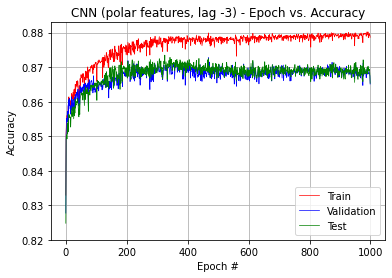

In [281]:
epochs = np.arange(0,num_epochs,1)

plt.plot(epochs, train, c="r", lw=0.7, label="Train")
plt.plot(epochs, val, c="b", lw=0.7, label="Validation")
plt.plot(epochs, test, c="g", lw=0.7, label="Test")
plt.grid(True)
plt.legend(loc="lower right")
plt.title(f"CNN ({features} features, lag {lag}) - Epoch vs. Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch #")
plt.yticks(np.arange(0.82,0.88,0.01))

## CORE ML

## ONNX

In [67]:
import onnx

In [68]:
cnn.eval()
dummy_input = torch.randn(1, 1, 28, 28)
input_names = [ "actual_input" ]
output_names = [ "output" ]
model = cnn

In [69]:
torch.onnx.export(model, 
                  dummy_input,
                  "polar-window10-lag0-cnn.onnx",
                  verbose=False,
                  input_names=input_names,
                  output_names=output_names,
                  export_params=True,
                  )

# LSTM

In [309]:
def eval_rnn(mod, data):
    preds = []
    actual = []
    
    shape = data.dataset.tensors[0].shape[1:]
    
    mod.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in data:
            images = images.reshape(-1, sequence_length, input_size).to(device)
            labels = labels.to(device)
            outputs = mod(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            preds.append(predicted)
            actual.append(labels)

        print(f'Accuracy of the model on the {total} samples: {100 * correct / total} %')
    return preds, actual, correct/total

In [310]:
# Hyper-parameters
sequence_length = 28
input_size = 28
hidden_size = 128
num_layers = 2
num_classes = 2
batch_size = 128
num_epochs = 1000
learning_rate = 0.01

In [311]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Set initial hidden and cell states 
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

In [312]:
epochs = {}

In [313]:
model = RNN(input_size, hidden_size, num_layers, num_classes).to(device)


# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_iterator)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_iterator):
        images = images.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
            epochs[epoch] = {"loss": loss.item(), "train": eval_rnn(model, train_iterator), 
                             "val": eval_rnn(model, val_iterator), "test": eval_rnn(model, test_iterator)} 
            
            model.train()

Epoch [1/1000], Step [100/295], Loss: 0.3599
Accuracy of the model on the 37644 samples: 83.38646265009032 %
Accuracy of the model on the 12548 samples: 82.6267134204654 %
Accuracy of the model on the 12548 samples: 82.41950908511316 %
Epoch [1/1000], Step [200/295], Loss: 0.5352
Accuracy of the model on the 37644 samples: 83.38646265009032 %
Accuracy of the model on the 12548 samples: 82.6267134204654 %
Accuracy of the model on the 12548 samples: 82.41950908511316 %
Epoch [2/1000], Step [100/295], Loss: 0.2937
Accuracy of the model on the 37644 samples: 84.81032833917756 %
Accuracy of the model on the 12548 samples: 84.42779725852725 %
Accuracy of the model on the 12548 samples: 84.14089894803953 %
Epoch [2/1000], Step [200/295], Loss: 0.4261
Accuracy of the model on the 37644 samples: 84.8342365317182 %
Accuracy of the model on the 12548 samples: 84.49155243863564 %
Accuracy of the model on the 12548 samples: 84.30825629582404 %
Epoch [3/1000], Step [100/295], Loss: 0.2910
Accuracy o

Accuracy of the model on the 12548 samples: 86.20497290404846 %
Epoch [18/1000], Step [200/295], Loss: 0.3712
Accuracy of the model on the 37644 samples: 87.2197428541069 %
Accuracy of the model on the 12548 samples: 86.6114121772394 %
Accuracy of the model on the 12548 samples: 86.18106471150782 %
Epoch [19/1000], Step [100/295], Loss: 0.2460
Accuracy of the model on the 37644 samples: 87.27287217086388 %
Accuracy of the model on the 12548 samples: 86.75486133248326 %
Accuracy of the model on the 12548 samples: 86.38029964934651 %
Epoch [19/1000], Step [200/295], Loss: 0.3736
Accuracy of the model on the 37644 samples: 87.06035490383594 %
Accuracy of the model on the 12548 samples: 86.54765699713101 %
Accuracy of the model on the 12548 samples: 86.48390181702263 %
Epoch [20/1000], Step [100/295], Loss: 0.2549
Accuracy of the model on the 37644 samples: 87.0523855063224 %
Accuracy of the model on the 12548 samples: 86.67516735734779 %
Accuracy of the model on the 12548 samples: 86.1651

Accuracy of the model on the 12548 samples: 86.39623844437361 %
Epoch [36/1000], Step [100/295], Loss: 0.2510
Accuracy of the model on the 37644 samples: 87.40038253108065 %
Accuracy of the model on the 12548 samples: 87.09754542556583 %
Accuracy of the model on the 12548 samples: 86.51577940707682 %
Epoch [36/1000], Step [200/295], Loss: 0.3676
Accuracy of the model on the 37644 samples: 87.08957602805228 %
Accuracy of the model on the 12548 samples: 86.65922856232069 %
Accuracy of the model on the 12548 samples: 86.11730953139943 %
Epoch [37/1000], Step [100/295], Loss: 0.2467
Accuracy of the model on the 37644 samples: 87.4136648602699 %
Accuracy of the model on the 12548 samples: 86.77080012751036 %
Accuracy of the model on the 12548 samples: 86.35639145680587 %
Epoch [37/1000], Step [200/295], Loss: 0.3625
Accuracy of the model on the 37644 samples: 87.21708638826905 %
Accuracy of the model on the 12548 samples: 86.83455530761874 %
Accuracy of the model on the 12548 samples: 86.32

Accuracy of the model on the 12548 samples: 86.93018807778132 %
Epoch [53/1000], Step [200/295], Loss: 0.3809
Accuracy of the model on the 37644 samples: 88.13622356816491 %
Accuracy of the model on the 12548 samples: 87.28881096589097 %
Accuracy of the model on the 12548 samples: 86.92221868026778 %
Epoch [54/1000], Step [100/295], Loss: 0.2224
Accuracy of the model on the 37644 samples: 88.27435979173308 %
Accuracy of the model on the 12548 samples: 87.4083519285942 %
Accuracy of the model on the 12548 samples: 87.0098820529168 %
Epoch [54/1000], Step [200/295], Loss: 0.3611
Accuracy of the model on the 37644 samples: 88.34342790351717 %
Accuracy of the model on the 12548 samples: 87.32865795345872 %
Accuracy of the model on the 12548 samples: 86.85846350015939 %
Epoch [55/1000], Step [100/295], Loss: 0.2207
Accuracy of the model on the 37644 samples: 88.13622356816491 %
Accuracy of the model on the 12548 samples: 87.09754542556583 %
Accuracy of the model on the 12548 samples: 86.722

Accuracy of the model on the 37644 samples: 88.19200935075975 %
Accuracy of the model on the 12548 samples: 87.05769843799808 %
Accuracy of the model on the 12548 samples: 86.85049410264584 %
Epoch [71/1000], Step [100/295], Loss: 0.2083
Accuracy of the model on the 37644 samples: 87.85198172351504 %
Accuracy of the model on the 12548 samples: 86.9939432578897 %
Accuracy of the model on the 12548 samples: 86.57156518967166 %
Epoch [71/1000], Step [200/295], Loss: 0.3562
Accuracy of the model on the 37644 samples: 88.53734990968016 %
Accuracy of the model on the 12548 samples: 87.69525023908193 %
Accuracy of the model on the 12548 samples: 87.4402295186484 %
Epoch [72/1000], Step [100/295], Loss: 0.2174
Accuracy of the model on the 37644 samples: 88.80830942514079 %
Accuracy of the model on the 12548 samples: 87.76697481670385 %
Accuracy of the model on the 12548 samples: 87.32068855594517 %
Epoch [72/1000], Step [200/295], Loss: 0.3473
Accuracy of the model on the 37644 samples: 88.837

Accuracy of the model on the 12548 samples: 87.36053554351291 %
Epoch [88/1000], Step [100/295], Loss: 0.2027
Accuracy of the model on the 37644 samples: 88.90659866114122 %
Accuracy of the model on the 12548 samples: 87.88651577940708 %
Accuracy of the model on the 12548 samples: 87.49601530124323 %
Epoch [88/1000], Step [200/295], Loss: 0.3224
Accuracy of the model on the 37644 samples: 89.3900754436298 %
Accuracy of the model on the 12548 samples: 88.26904686005739 %
Accuracy of the model on the 12548 samples: 87.52789289129741 %
Epoch [89/1000], Step [100/295], Loss: 0.2002
Accuracy of the model on the 37644 samples: 89.06864307725003 %
Accuracy of the model on the 12548 samples: 87.75103602167677 %
Accuracy of the model on the 12548 samples: 87.27287217086388 %
Epoch [89/1000], Step [200/295], Loss: 0.3344
Accuracy of the model on the 37644 samples: 88.54531930719371 %
Accuracy of the model on the 12548 samples: 87.82276059929869 %
Accuracy of the model on the 12548 samples: 87.30

Accuracy of the model on the 37644 samples: 88.80034002762724 %
Accuracy of the model on the 12548 samples: 87.52789289129741 %
Accuracy of the model on the 12548 samples: 87.33662735097226 %
Epoch [105/1000], Step [200/295], Loss: 0.3293
Accuracy of the model on the 37644 samples: 88.91988099033047 %
Accuracy of the model on the 12548 samples: 87.53586228881096 %
Accuracy of the model on the 12548 samples: 87.36850494102646 %
Epoch [106/1000], Step [100/295], Loss: 0.2117
Accuracy of the model on the 37644 samples: 89.69556901498247 %
Accuracy of the model on the 12548 samples: 87.7908830092445 %
Accuracy of the model on the 12548 samples: 87.82276059929869 %
Epoch [106/1000], Step [200/295], Loss: 0.3486
Accuracy of the model on the 37644 samples: 89.02082669216874 %
Accuracy of the model on the 12548 samples: 87.59961746891935 %
Accuracy of the model on the 12548 samples: 87.48804590372968 %
Epoch [107/1000], Step [100/295], Loss: 0.2170
Accuracy of the model on the 37644 samples: 8

Accuracy of the model on the 12548 samples: 87.3924131335671 %
Epoch [122/1000], Step [200/295], Loss: 0.3192
Accuracy of the model on the 37644 samples: 89.29178620762937 %
Accuracy of the model on the 12548 samples: 87.92636276697482 %
Accuracy of the model on the 12548 samples: 87.83869939432579 %
Epoch [123/1000], Step [100/295], Loss: 0.2503
Accuracy of the model on the 37644 samples: 88.43109127616619 %
Accuracy of the model on the 12548 samples: 87.12145361810647 %
Accuracy of the model on the 12548 samples: 86.92221868026778 %
Epoch [123/1000], Step [200/295], Loss: 0.3475
Accuracy of the model on the 37644 samples: 88.78971416427585 %
Accuracy of the model on the 12548 samples: 87.5916480714058 %
Accuracy of the model on the 12548 samples: 87.21708638826905 %
Epoch [124/1000], Step [100/295], Loss: 0.1991
Accuracy of the model on the 37644 samples: 89.37148018276486 %
Accuracy of the model on the 12548 samples: 87.87057698437998 %
Accuracy of the model on the 12548 samples: 87

Accuracy of the model on the 37644 samples: 89.45117415790033 %
Accuracy of the model on the 12548 samples: 87.85463818935288 %
Accuracy of the model on the 12548 samples: 87.65540325151419 %
Epoch [140/1000], Step [100/295], Loss: 0.2144
Accuracy of the model on the 37644 samples: 89.18818403995324 %
Accuracy of the model on the 12548 samples: 87.63946445648709 %
Accuracy of the model on the 12548 samples: 87.53586228881096 %
Epoch [140/1000], Step [200/295], Loss: 0.3419
Accuracy of the model on the 37644 samples: 89.71947720752311 %
Accuracy of the model on the 12548 samples: 88.01402613962385 %
Accuracy of the model on the 12548 samples: 87.94230156200192 %
Epoch [141/1000], Step [100/295], Loss: 0.2037
Accuracy of the model on the 37644 samples: 89.1377111890341 %
Accuracy of the model on the 12548 samples: 87.87057698437998 %
Accuracy of the model on the 12548 samples: 87.47210710870259 %
Epoch [141/1000], Step [200/295], Loss: 0.3430
Accuracy of the model on the 37644 samples: 8

Accuracy of the model on the 12548 samples: 87.79885240675804 %
Epoch [157/1000], Step [100/295], Loss: 0.2339
Accuracy of the model on the 37644 samples: 87.33131441929656 %
Accuracy of the model on the 12548 samples: 87.01785145043034 %
Accuracy of the model on the 12548 samples: 86.42014663691425 %
Epoch [157/1000], Step [200/295], Loss: 0.3444
Accuracy of the model on the 37644 samples: 88.94113271703326 %
Accuracy of the model on the 12548 samples: 87.67931144405483 %
Accuracy of the model on the 12548 samples: 87.63946445648709 %
Epoch [158/1000], Step [100/295], Loss: 0.2153
Accuracy of the model on the 37644 samples: 89.08723833811497 %
Accuracy of the model on the 12548 samples: 87.56773987886515 %
Accuracy of the model on the 12548 samples: 87.52789289129741 %
Epoch [158/1000], Step [200/295], Loss: 0.3316
Accuracy of the model on the 37644 samples: 89.70619487833386 %
Accuracy of the model on the 12548 samples: 88.06184252470513 %
Accuracy of the model on the 12548 samples: 

Accuracy of the model on the 37644 samples: 89.60259271065775 %
Accuracy of the model on the 12548 samples: 88.03793433216448 %
Accuracy of the model on the 12548 samples: 87.32068855594517 %
Epoch [174/1000], Step [200/295], Loss: 0.3144
Accuracy of the model on the 37644 samples: 89.68228668579322 %
Accuracy of the model on the 12548 samples: 87.74306662416322 %
Accuracy of the model on the 12548 samples: 87.47210710870259 %
Epoch [175/1000], Step [100/295], Loss: 0.1949
Accuracy of the model on the 37644 samples: 90.391563064499 %
Accuracy of the model on the 12548 samples: 88.24513866751674 %
Accuracy of the model on the 12548 samples: 87.91042397194772 %
Epoch [175/1000], Step [200/295], Loss: 0.2984
Accuracy of the model on the 37644 samples: 90.05419190309213 %
Accuracy of the model on the 12548 samples: 87.87057698437998 %
Accuracy of the model on the 12548 samples: 87.48804590372968 %
Epoch [176/1000], Step [100/295], Loss: 0.1959
Accuracy of the model on the 37644 samples: 90

Accuracy of the model on the 12548 samples: 87.90245457443417 %
Epoch [191/1000], Step [200/295], Loss: 0.2973
Accuracy of the model on the 37644 samples: 90.73690362341941 %
Accuracy of the model on the 12548 samples: 88.34874083519286 %
Accuracy of the model on the 12548 samples: 88.1734140898948 %
Epoch [192/1000], Step [100/295], Loss: 0.1730
Accuracy of the model on the 37644 samples: 89.78588885346934 %
Accuracy of the model on the 12548 samples: 87.84666879183933 %
Accuracy of the model on the 12548 samples: 87.51195409627032 %
Epoch [192/1000], Step [200/295], Loss: 0.3515
Accuracy of the model on the 37644 samples: 89.1855275741154 %
Accuracy of the model on the 12548 samples: 87.28084156837743 %
Accuracy of the model on the 12548 samples: 87.14536181064712 %
Epoch [193/1000], Step [100/295], Loss: 0.1934
Accuracy of the model on the 37644 samples: 89.28116034427798 %
Accuracy of the model on the 12548 samples: 87.66337264902774 %
Accuracy of the model on the 12548 samples: 87

Accuracy of the model on the 37644 samples: 90.83519285941983 %
Accuracy of the model on the 12548 samples: 87.88651577940708 %
Accuracy of the model on the 12548 samples: 87.9901179470832 %
Epoch [209/1000], Step [100/295], Loss: 0.1848
Accuracy of the model on the 37644 samples: 90.67580490914887 %
Accuracy of the model on the 12548 samples: 88.03793433216448 %
Accuracy of the model on the 12548 samples: 87.5597704813516 %
Epoch [209/1000], Step [200/295], Loss: 0.2828
Accuracy of the model on the 37644 samples: 90.73956008925725 %
Accuracy of the model on the 12548 samples: 88.13356710232706 %
Accuracy of the model on the 12548 samples: 87.73509722664967 %
Epoch [210/1000], Step [100/295], Loss: 0.1835
Accuracy of the model on the 37644 samples: 90.45000531293168 %
Accuracy of the model on the 12548 samples: 87.99808734459675 %
Accuracy of the model on the 12548 samples: 87.89448517692063 %
Epoch [210/1000], Step [200/295], Loss: 0.3045
Accuracy of the model on the 37644 samples: 89

Accuracy of the model on the 12548 samples: 87.49601530124323 %
Epoch [226/1000], Step [100/295], Loss: 0.2082
Accuracy of the model on the 37644 samples: 89.87089576028052 %
Accuracy of the model on the 12548 samples: 87.91839336946127 %
Accuracy of the model on the 12548 samples: 87.44819891616194 %
Epoch [226/1000], Step [200/295], Loss: 0.3260
Accuracy of the model on the 37644 samples: 90.24014451174158 %
Accuracy of the model on the 12548 samples: 87.5757092763787 %
Accuracy of the model on the 12548 samples: 87.45616831367549 %
Epoch [227/1000], Step [100/295], Loss: 0.1812
Accuracy of the model on the 37644 samples: 90.99458080969079 %
Accuracy of the model on the 12548 samples: 88.01402613962385 %
Accuracy of the model on the 12548 samples: 87.68728084156838 %
Epoch [227/1000], Step [200/295], Loss: 0.3044
Accuracy of the model on the 37644 samples: 89.80979704600999 %
Accuracy of the model on the 12548 samples: 86.92221868026778 %
Accuracy of the model on the 12548 samples: 8

Accuracy of the model on the 37644 samples: 91.22569333758368 %
Accuracy of the model on the 12548 samples: 87.75103602167677 %
Accuracy of the model on the 12548 samples: 87.7749442142174 %
Epoch [243/1000], Step [200/295], Loss: 0.2688
Accuracy of the model on the 37644 samples: 91.12474763574541 %
Accuracy of the model on the 12548 samples: 87.67134204654128 %
Accuracy of the model on the 12548 samples: 87.74306662416322 %
Epoch [244/1000], Step [100/295], Loss: 0.2100
Accuracy of the model on the 37644 samples: 90.14716820741685 %
Accuracy of the model on the 12548 samples: 86.93018807778132 %
Accuracy of the model on the 12548 samples: 86.88237169270003 %
Epoch [244/1000], Step [200/295], Loss: 0.3193
Accuracy of the model on the 37644 samples: 90.27467856763361 %
Accuracy of the model on the 12548 samples: 87.20114759324196 %
Accuracy of the model on the 12548 samples: 87.44819891616194 %
Epoch [245/1000], Step [100/295], Loss: 0.2174
Accuracy of the model on the 37644 samples: 9

Accuracy of the model on the 12548 samples: 86.50781000956327 %
Epoch [260/1000], Step [200/295], Loss: 0.3362
Accuracy of the model on the 37644 samples: 88.80034002762724 %
Accuracy of the model on the 12548 samples: 87.81479120178514 %
Accuracy of the model on the 12548 samples: 87.15333120816067 %
Epoch [261/1000], Step [100/295], Loss: 0.2440
Accuracy of the model on the 37644 samples: 89.19880990330465 %
Accuracy of the model on the 12548 samples: 87.91839336946127 %
Accuracy of the model on the 12548 samples: 87.45616831367549 %
Epoch [261/1000], Step [200/295], Loss: 0.3625
Accuracy of the model on the 37644 samples: 88.90394219530337 %
Accuracy of the model on the 12548 samples: 87.67134204654128 %
Accuracy of the model on the 12548 samples: 87.28881096589097 %
Epoch [262/1000], Step [100/295], Loss: 0.1964
Accuracy of the model on the 37644 samples: 90.69440017001381 %
Accuracy of the model on the 12548 samples: 88.24513866751674 %
Accuracy of the model on the 12548 samples: 

Accuracy of the model on the 37644 samples: 86.22888109658909 %
Accuracy of the model on the 12548 samples: 86.02167676123685 %
Accuracy of the model on the 12548 samples: 85.49569652534268 %
Epoch [278/1000], Step [100/295], Loss: 0.3162
Accuracy of the model on the 37644 samples: 86.51312294123898 %
Accuracy of the model on the 12548 samples: 86.16512591648072 %
Accuracy of the model on the 12548 samples: 85.4319413452343 %
Epoch [278/1000], Step [200/295], Loss: 0.4314
Accuracy of the model on the 37644 samples: 86.34310912761661 %
Accuracy of the model on the 12548 samples: 86.212942301562 %
Accuracy of the model on the 12548 samples: 85.59929869301881 %
Epoch [279/1000], Step [100/295], Loss: 0.3104
Accuracy of the model on the 37644 samples: 86.19965997237276 %
Accuracy of the model on the 12548 samples: 85.7985336308575 %
Accuracy of the model on the 12548 samples: 85.35224737009882 %
Epoch [279/1000], Step [200/295], Loss: 0.4297
Accuracy of the model on the 37644 samples: 86.3

Accuracy of the model on the 12548 samples: 85.92604399107428 %
Epoch [295/1000], Step [100/295], Loss: 0.2672
Accuracy of the model on the 37644 samples: 86.90627988524068 %
Accuracy of the model on the 12548 samples: 86.37233025183296 %
Accuracy of the model on the 12548 samples: 85.96589097864201 %
Epoch [295/1000], Step [200/295], Loss: 0.3748
Accuracy of the model on the 37644 samples: 87.02847731378175 %
Accuracy of the model on the 12548 samples: 86.46796302199554 %
Accuracy of the model on the 12548 samples: 86.04558495377749 %
Epoch [296/1000], Step [100/295], Loss: 0.2723
Accuracy of the model on the 37644 samples: 87.03910317713314 %
Accuracy of the model on the 12548 samples: 86.4121772394007 %
Accuracy of the model on the 12548 samples: 86.06949314631814 %
Epoch [296/1000], Step [200/295], Loss: 0.3586
Accuracy of the model on the 37644 samples: 87.235681649134 %
Accuracy of the model on the 12548 samples: 86.6273509722665 %
Accuracy of the model on the 12548 samples: 86.1

Accuracy of the model on the 37644 samples: 86.26341515248114 %
Accuracy of the model on the 12548 samples: 85.94995218361493 %
Accuracy of the model on the 12548 samples: 85.59132929550526 %
Epoch [312/1000], Step [200/295], Loss: 0.4095
Accuracy of the model on the 37644 samples: 87.15067474232282 %
Accuracy of the model on the 12548 samples: 86.57156518967166 %
Accuracy of the model on the 12548 samples: 86.26075868664329 %
Epoch [313/1000], Step [100/295], Loss: 0.2737
Accuracy of the model on the 37644 samples: 87.17458293486345 %
Accuracy of the model on the 12548 samples: 86.58750398469876 %
Accuracy of the model on the 12548 samples: 86.23685049410264 %
Epoch [313/1000], Step [200/295], Loss: 0.3804
Accuracy of the model on the 37644 samples: 87.07098076718734 %
Accuracy of the model on the 12548 samples: 86.6432897672936 %
Accuracy of the model on the 12548 samples: 86.06152374880459 %
Epoch [314/1000], Step [100/295], Loss: 0.2548
Accuracy of the model on the 37644 samples: 8

Accuracy of the model on the 12548 samples: 86.14121772394007 %
Epoch [329/1000], Step [200/295], Loss: 0.3664
Accuracy of the model on the 37644 samples: 87.47476357454043 %
Accuracy of the model on the 12548 samples: 86.49187121453618 %
Accuracy of the model on the 12548 samples: 86.30857507172458 %
Epoch [330/1000], Step [100/295], Loss: 0.2555
Accuracy of the model on the 37644 samples: 87.53054935713527 %
Accuracy of the model on the 12548 samples: 86.77080012751036 %
Accuracy of the model on the 12548 samples: 86.4281160344278 %
Epoch [330/1000], Step [200/295], Loss: 0.3504
Accuracy of the model on the 37644 samples: 87.24365104664754 %
Accuracy of the model on the 12548 samples: 86.9939432578897 %
Accuracy of the model on the 12548 samples: 86.27669748167038 %
Epoch [331/1000], Step [100/295], Loss: 0.2432
Accuracy of the model on the 37644 samples: 87.65540325151419 %
Accuracy of the model on the 12548 samples: 86.69907554988843 %
Accuracy of the model on the 12548 samples: 86

Accuracy of the model on the 37644 samples: 87.39772606524281 %
Accuracy of the model on the 12548 samples: 86.93815747529487 %
Accuracy of the model on the 12548 samples: 86.33248326426522 %
Epoch [347/1000], Step [100/295], Loss: 0.2344
Accuracy of the model on the 37644 samples: 88.34608436935501 %
Accuracy of the model on the 12548 samples: 87.61555626394644 %
Accuracy of the model on the 12548 samples: 87.12942301562002 %
Epoch [347/1000], Step [200/295], Loss: 0.3941
Accuracy of the model on the 37644 samples: 87.50664116459463 %
Accuracy of the model on the 12548 samples: 86.63532036978005 %
Accuracy of the model on the 12548 samples: 86.31654446923812 %
Epoch [348/1000], Step [100/295], Loss: 0.2496
Accuracy of the model on the 37644 samples: 88.41249601530124 %
Accuracy of the model on the 12548 samples: 87.30474976091807 %
Accuracy of the model on the 12548 samples: 87.05769843799808 %
Epoch [348/1000], Step [200/295], Loss: 0.3586
Accuracy of the model on the 37644 samples: 

Accuracy of the model on the 12548 samples: 87.27287217086388 %
Epoch [364/1000], Step [100/295], Loss: 0.2540
Accuracy of the model on the 37644 samples: 88.02730846881309 %
Accuracy of the model on the 12548 samples: 87.15333120816067 %
Accuracy of the model on the 12548 samples: 86.70704494740198 %
Epoch [364/1000], Step [200/295], Loss: 0.3443
Accuracy of the model on the 37644 samples: 88.27701625757092 %
Accuracy of the model on the 12548 samples: 87.4083519285942 %
Accuracy of the model on the 12548 samples: 87.18520879821486 %
Epoch [365/1000], Step [100/295], Loss: 0.2719
Accuracy of the model on the 37644 samples: 88.04856019551589 %
Accuracy of the model on the 12548 samples: 87.46413771118904 %
Accuracy of the model on the 12548 samples: 86.77080012751036 %
Epoch [365/1000], Step [200/295], Loss: 0.3465
Accuracy of the model on the 37644 samples: 88.14153649984061 %
Accuracy of the model on the 12548 samples: 87.19317819572841 %
Accuracy of the model on the 12548 samples: 8

Accuracy of the model on the 37644 samples: 88.83487408351928 %
Accuracy of the model on the 12548 samples: 87.67931144405483 %
Accuracy of the model on the 12548 samples: 87.4083519285942 %
Epoch [381/1000], Step [200/295], Loss: 0.3480
Accuracy of the model on the 37644 samples: 87.63149505897354 %
Accuracy of the model on the 12548 samples: 86.794708320051 %
Accuracy of the model on the 12548 samples: 86.57953458718521 %
Epoch [382/1000], Step [100/295], Loss: 0.2225
Accuracy of the model on the 37644 samples: 88.1893528849219 %
Accuracy of the model on the 12548 samples: 87.51992349378386 %
Accuracy of the model on the 12548 samples: 87.10551482307937 %
Epoch [382/1000], Step [200/295], Loss: 0.3651
Accuracy of the model on the 37644 samples: 88.03793433216448 %
Accuracy of the model on the 12548 samples: 87.11348422059292 %
Accuracy of the model on the 12548 samples: 86.7787695250239 %
Epoch [383/1000], Step [100/295], Loss: 0.2527
Accuracy of the model on the 37644 samples: 88.68

Accuracy of the model on the 12548 samples: 87.23302518329615 %
Epoch [398/1000], Step [200/295], Loss: 0.3439
Accuracy of the model on the 37644 samples: 88.68876846243758 %
Accuracy of the model on the 12548 samples: 87.67134204654128 %
Accuracy of the model on the 12548 samples: 87.32068855594517 %
Epoch [399/1000], Step [100/295], Loss: 0.2367
Accuracy of the model on the 37644 samples: 89.05536074806078 %
Accuracy of the model on the 12548 samples: 88.01402613962385 %
Accuracy of the model on the 12548 samples: 87.6075868664329 %
Epoch [399/1000], Step [200/295], Loss: 0.3514
Accuracy of the model on the 37644 samples: 88.27967272340878 %
Accuracy of the model on the 12548 samples: 87.32068855594517 %
Accuracy of the model on the 12548 samples: 86.69907554988843 %
Epoch [400/1000], Step [100/295], Loss: 0.2246
Accuracy of the model on the 37644 samples: 88.91191159281692 %
Accuracy of the model on the 12548 samples: 88.29295505259802 %
Accuracy of the model on the 12548 samples: 8

Accuracy of the model on the 37644 samples: 88.83487408351928 %
Accuracy of the model on the 12548 samples: 87.73509722664967 %
Accuracy of the model on the 12548 samples: 87.09754542556583 %
Epoch [416/1000], Step [100/295], Loss: 0.2138
Accuracy of the model on the 37644 samples: 89.16161938157475 %
Accuracy of the model on the 12548 samples: 88.2212304749761 %
Accuracy of the model on the 12548 samples: 87.5916480714058 %
Epoch [416/1000], Step [200/295], Loss: 0.3582
Accuracy of the model on the 37644 samples: 89.08723833811497 %
Accuracy of the model on the 12548 samples: 88.0060567421103 %
Accuracy of the model on the 12548 samples: 87.32865795345872 %
Epoch [417/1000], Step [100/295], Loss: 0.2222
Accuracy of the model on the 37644 samples: 88.86940813941133 %
Accuracy of the model on the 12548 samples: 88.05387312719158 %
Accuracy of the model on the 12548 samples: 87.20114759324196 %
Epoch [417/1000], Step [200/295], Loss: 0.4336
Accuracy of the model on the 37644 samples: 87.

Accuracy of the model on the 12548 samples: 87.27287217086388 %
Epoch [433/1000], Step [100/295], Loss: 0.2267
Accuracy of the model on the 37644 samples: 88.69939432578897 %
Accuracy of the model on the 12548 samples: 87.94230156200192 %
Accuracy of the model on the 12548 samples: 87.11348422059292 %
Epoch [433/1000], Step [200/295], Loss: 0.3133
Accuracy of the model on the 37644 samples: 88.77111890341091 %
Accuracy of the model on the 12548 samples: 88.14950589735416 %
Accuracy of the model on the 12548 samples: 87.38444373605356 %
Epoch [434/1000], Step [100/295], Loss: 0.2114
Accuracy of the model on the 37644 samples: 89.1695887790883 %
Accuracy of the model on the 12548 samples: 88.10168951227287 %
Accuracy of the model on the 12548 samples: 87.41632132610775 %
Epoch [434/1000], Step [200/295], Loss: 0.3296
Accuracy of the model on the 37644 samples: 88.94378918287111 %
Accuracy of the model on the 12548 samples: 87.97417915205611 %
Accuracy of the model on the 12548 samples: 8

Accuracy of the model on the 37644 samples: 89.32366379768357 %
Accuracy of the model on the 12548 samples: 88.23716927000319 %
Accuracy of the model on the 12548 samples: 87.47210710870259 %
Epoch [450/1000], Step [200/295], Loss: 0.3302
Accuracy of the model on the 37644 samples: 89.12974179152056 %
Accuracy of the model on the 12548 samples: 87.95824035702901 %
Accuracy of the model on the 12548 samples: 87.43226012113485 %
Epoch [451/1000], Step [100/295], Loss: 0.2135
Accuracy of the model on the 37644 samples: 89.40070130698119 %
Accuracy of the model on the 12548 samples: 88.28498565508447 %
Accuracy of the model on the 12548 samples: 87.4083519285942 %
Epoch [451/1000], Step [200/295], Loss: 0.3425
Accuracy of the model on the 37644 samples: 89.20412283498034 %
Accuracy of the model on the 12548 samples: 88.02199553713739 %
Accuracy of the model on the 12548 samples: 87.5916480714058 %
Epoch [452/1000], Step [100/295], Loss: 0.2096
Accuracy of the model on the 37644 samples: 89

Accuracy of the model on the 12548 samples: 87.09754542556583 %
Epoch [467/1000], Step [200/295], Loss: 0.3067
Accuracy of the model on the 37644 samples: 89.06333014557433 %
Accuracy of the model on the 12548 samples: 88.03793433216448 %
Accuracy of the model on the 12548 samples: 87.19317819572841 %
Epoch [468/1000], Step [100/295], Loss: 0.2161
Accuracy of the model on the 37644 samples: 88.68345553076188 %
Accuracy of the model on the 12548 samples: 87.83072999681224 %
Accuracy of the model on the 12548 samples: 86.97800446286261 %
Epoch [468/1000], Step [200/295], Loss: 0.3179
Accuracy of the model on the 37644 samples: 89.16693231325046 %
Accuracy of the model on the 12548 samples: 87.84666879183933 %
Accuracy of the model on the 12548 samples: 87.53586228881096 %
Epoch [469/1000], Step [100/295], Loss: 0.2100
Accuracy of the model on the 37644 samples: 89.30241207098076 %
Accuracy of the model on the 12548 samples: 88.14153649984061 %
Accuracy of the model on the 12548 samples: 

Accuracy of the model on the 37644 samples: 89.33960259271066 %
Accuracy of the model on the 12548 samples: 87.97417915205611 %
Accuracy of the model on the 12548 samples: 87.63149505897354 %
Epoch [485/1000], Step [100/295], Loss: 0.2008
Accuracy of the model on the 37644 samples: 89.24131335671024 %
Accuracy of the model on the 12548 samples: 88.1893528849219 %
Accuracy of the model on the 12548 samples: 87.34459674848581 %
Epoch [485/1000], Step [200/295], Loss: 0.3174
Accuracy of the model on the 37644 samples: 89.37679311444055 %
Accuracy of the model on the 12548 samples: 88.10965890978642 %
Accuracy of the model on the 12548 samples: 87.5757092763787 %
Epoch [486/1000], Step [100/295], Loss: 0.1972
Accuracy of the model on the 37644 samples: 89.42726596535968 %
Accuracy of the model on the 12548 samples: 88.02199553713739 %
Accuracy of the model on the 12548 samples: 87.30474976091807 %
Epoch [486/1000], Step [200/295], Loss: 0.3341
Accuracy of the model on the 37644 samples: 89

Accuracy of the model on the 12548 samples: 86.98597386037615 %
Epoch [502/1000], Step [100/295], Loss: 0.2081
Accuracy of the model on the 37644 samples: 89.67166082244182 %
Accuracy of the model on the 12548 samples: 87.98214854956966 %
Accuracy of the model on the 12548 samples: 87.4242907236213 %
Epoch [502/1000], Step [200/295], Loss: 0.3300
Accuracy of the model on the 37644 samples: 89.46180002125173 %
Accuracy of the model on the 12548 samples: 88.05387312719158 %
Accuracy of the model on the 12548 samples: 87.5757092763787 %
Epoch [503/1000], Step [100/295], Loss: 0.1887
Accuracy of the model on the 37644 samples: 89.61853150568484 %
Accuracy of the model on the 12548 samples: 88.41249601530124 %
Accuracy of the model on the 12548 samples: 87.32068855594517 %
Epoch [503/1000], Step [200/295], Loss: 0.3517
Accuracy of the model on the 37644 samples: 89.31303793433216 %
Accuracy of the model on the 12548 samples: 87.99808734459675 %
Accuracy of the model on the 12548 samples: 87

Accuracy of the model on the 37644 samples: 89.43789182871109 %
Accuracy of the model on the 12548 samples: 87.97417915205611 %
Accuracy of the model on the 12548 samples: 87.24896397832323 %
Epoch [519/1000], Step [200/295], Loss: 0.3341
Accuracy of the model on the 37644 samples: 89.09786420146636 %
Accuracy of the model on the 12548 samples: 87.51195409627032 %
Accuracy of the model on the 12548 samples: 87.4242907236213 %
Epoch [520/1000], Step [100/295], Loss: 0.1867
Accuracy of the model on the 37644 samples: 89.74869833173945 %
Accuracy of the model on the 12548 samples: 88.19732228243545 %
Accuracy of the model on the 12548 samples: 87.75103602167677 %
Epoch [520/1000], Step [200/295], Loss: 0.2898
Accuracy of the model on the 37644 samples: 89.80182764849644 %
Accuracy of the model on the 12548 samples: 88.1734140898948 %
Accuracy of the model on the 12548 samples: 87.68728084156838 %
Epoch [521/1000], Step [100/295], Loss: 0.1940
Accuracy of the model on the 37644 samples: 89

Accuracy of the model on the 12548 samples: 86.9939432578897 %
Epoch [536/1000], Step [200/295], Loss: 0.3383
Accuracy of the model on the 37644 samples: 89.48305174795452 %
Accuracy of the model on the 12548 samples: 88.02996493465093 %
Accuracy of the model on the 12548 samples: 87.48804590372968 %
Epoch [537/1000], Step [100/295], Loss: 0.1773
Accuracy of the model on the 37644 samples: 90.06747423228137 %
Accuracy of the model on the 12548 samples: 88.19732228243545 %
Accuracy of the model on the 12548 samples: 87.50398469875677 %
Epoch [537/1000], Step [200/295], Loss: 0.2604
Accuracy of the model on the 37644 samples: 89.71150781000956 %
Accuracy of the model on the 12548 samples: 87.90245457443417 %
Accuracy of the model on the 12548 samples: 87.5597704813516 %
Epoch [538/1000], Step [100/295], Loss: 0.2141
Accuracy of the model on the 37644 samples: 89.3900754436298 %
Accuracy of the model on the 12548 samples: 87.70321963659548 %
Accuracy of the model on the 12548 samples: 87.

Accuracy of the model on the 37644 samples: 89.3847625119541 %
Accuracy of the model on the 12548 samples: 87.69525023908193 %
Accuracy of the model on the 12548 samples: 87.24896397832323 %
Epoch [554/1000], Step [100/295], Loss: 0.1952
Accuracy of the model on the 37644 samples: 90.02762724471363 %
Accuracy of the model on the 12548 samples: 87.7908830092445 %
Accuracy of the model on the 12548 samples: 87.71118903410903 %
Epoch [554/1000], Step [200/295], Loss: 0.2724
Accuracy of the model on the 37644 samples: 89.5468069280629 %
Accuracy of the model on the 12548 samples: 87.67134204654128 %
Accuracy of the model on the 12548 samples: 87.38444373605356 %
Epoch [555/1000], Step [100/295], Loss: 0.1665
Accuracy of the model on the 37644 samples: 90.07278716395707 %
Accuracy of the model on the 12548 samples: 88.03793433216448 %
Accuracy of the model on the 12548 samples: 87.74306662416322 %
Epoch [555/1000], Step [200/295], Loss: 0.3268
Accuracy of the model on the 37644 samples: 89.

Accuracy of the model on the 12548 samples: 85.95792158112846 %
Epoch [571/1000], Step [100/295], Loss: 0.2404
Accuracy of the model on the 37644 samples: 86.98066092870046 %
Accuracy of the model on the 12548 samples: 86.52374880459037 %
Accuracy of the model on the 12548 samples: 86.07746254383169 %
Epoch [571/1000], Step [200/295], Loss: 0.3632
Accuracy of the model on the 37644 samples: 86.89831048772713 %
Accuracy of the model on the 12548 samples: 86.77080012751036 %
Accuracy of the model on the 12548 samples: 86.08543194134523 %
Epoch [572/1000], Step [100/295], Loss: 0.2651
Accuracy of the model on the 37644 samples: 87.20114759324196 %
Accuracy of the model on the 12548 samples: 86.86643289767294 %
Accuracy of the model on the 12548 samples: 86.28466687918393 %
Epoch [572/1000], Step [200/295], Loss: 0.3698
Accuracy of the model on the 37644 samples: 87.12676654978218 %
Accuracy of the model on the 12548 samples: 86.97003506534907 %
Accuracy of the model on the 12548 samples: 

Accuracy of the model on the 37644 samples: 85.8357241525874 %
Accuracy of the model on the 12548 samples: 85.29646158750398 %
Accuracy of the model on the 12548 samples: 85.47178833280203 %
Epoch [588/1000], Step [200/295], Loss: 0.5284
Accuracy of the model on the 37644 samples: 83.59101051960472 %
Accuracy of the model on the 12548 samples: 82.84188715333121 %
Accuracy of the model on the 12548 samples: 82.58686643289768 %
Epoch [589/1000], Step [100/295], Loss: 0.3893
Accuracy of the model on the 37644 samples: 83.44224843268516 %
Accuracy of the model on the 12548 samples: 83.32005100414409 %
Accuracy of the model on the 12548 samples: 82.76219317819573 %
Epoch [589/1000], Step [200/295], Loss: 0.4710
Accuracy of the model on the 37644 samples: 84.48623950695995 %
Accuracy of the model on the 12548 samples: 83.83009244501116 %
Accuracy of the model on the 12548 samples: 83.50334714695569 %
Epoch [590/1000], Step [100/295], Loss: 0.3122
Accuracy of the model on the 37644 samples: 8

Accuracy of the model on the 12548 samples: 85.2486452024227 %
Epoch [605/1000], Step [200/295], Loss: 0.4022
Accuracy of the model on the 37644 samples: 85.9818297736691 %
Accuracy of the model on the 12548 samples: 85.40803315269366 %
Accuracy of the model on the 12548 samples: 85.2008288173414 %
Epoch [606/1000], Step [100/295], Loss: 0.2725
Accuracy of the model on the 37644 samples: 86.35639145680587 %
Accuracy of the model on the 12548 samples: 85.77462543831686 %
Accuracy of the model on the 12548 samples: 85.27255339496334 %
Epoch [606/1000], Step [200/295], Loss: 0.4134
Accuracy of the model on the 37644 samples: 86.212942301562 %
Accuracy of the model on the 12548 samples: 85.74274784826267 %
Accuracy of the model on the 12548 samples: 85.38412496015302 %
Epoch [607/1000], Step [100/295], Loss: 0.2591
Accuracy of the model on the 37644 samples: 85.66836680480289 %
Accuracy of the model on the 12548 samples: 85.09722664966529 %
Accuracy of the model on the 12548 samples: 84.78

Accuracy of the model on the 37644 samples: 86.86643289767294 %
Accuracy of the model on the 12548 samples: 86.32451386675167 %
Accuracy of the model on the 12548 samples: 85.88619700350654 %
Epoch [623/1000], Step [100/295], Loss: 0.2544
Accuracy of the model on the 37644 samples: 87.03379024545744 %
Accuracy of the model on the 12548 samples: 86.26075868664329 %
Accuracy of the model on the 12548 samples: 86.13324832642652 %
Epoch [623/1000], Step [200/295], Loss: 0.3885
Accuracy of the model on the 37644 samples: 86.94081394113272 %
Accuracy of the model on the 12548 samples: 86.27669748167038 %
Accuracy of the model on the 12548 samples: 85.88619700350654 %
Epoch [624/1000], Step [100/295], Loss: 0.2520
Accuracy of the model on the 37644 samples: 86.9992561895654 %
Accuracy of the model on the 12548 samples: 86.26872808415683 %
Accuracy of the model on the 12548 samples: 86.12527892891298 %
Epoch [624/1000], Step [200/295], Loss: 0.3664
Accuracy of the model on the 37644 samples: 8

Accuracy of the model on the 12548 samples: 86.17309531399427 %
Epoch [640/1000], Step [100/295], Loss: 0.2443
Accuracy of the model on the 37644 samples: 87.31006269259377 %
Accuracy of the model on the 12548 samples: 86.6432897672936 %
Accuracy of the model on the 12548 samples: 86.37233025183296 %
Epoch [640/1000], Step [200/295], Loss: 0.3845
Accuracy of the model on the 37644 samples: 87.07098076718734 %
Accuracy of the model on the 12548 samples: 86.48390181702263 %
Accuracy of the model on the 12548 samples: 85.83838061842525 %
Epoch [641/1000], Step [100/295], Loss: 0.2386
Accuracy of the model on the 37644 samples: 87.47742004037828 %
Accuracy of the model on the 12548 samples: 86.75486133248326 %
Accuracy of the model on the 12548 samples: 86.53968759961747 %
Epoch [641/1000], Step [200/295], Loss: 0.4171
Accuracy of the model on the 37644 samples: 86.50781000956327 %
Accuracy of the model on the 12548 samples: 85.87025820847944 %
Accuracy of the model on the 12548 samples: 8

Accuracy of the model on the 37644 samples: 85.69758792901924 %
Accuracy of the model on the 12548 samples: 85.40006375518011 %
Accuracy of the model on the 12548 samples: 84.92986930188077 %
Epoch [657/1000], Step [200/295], Loss: 0.4651
Accuracy of the model on the 37644 samples: 85.4319413452343 %
Accuracy of the model on the 12548 samples: 85.0015938795027 %
Accuracy of the model on the 12548 samples: 84.8501753267453 %
Epoch [658/1000], Step [100/295], Loss: 0.3034
Accuracy of the model on the 37644 samples: 85.88088407183083 %
Accuracy of the model on the 12548 samples: 85.42397194772076 %
Accuracy of the model on the 12548 samples: 85.05737966209755 %
Epoch [658/1000], Step [200/295], Loss: 0.4276
Accuracy of the model on the 37644 samples: 86.09340133885878 %
Accuracy of the model on the 12548 samples: 85.95792158112846 %
Accuracy of the model on the 12548 samples: 85.2486452024227 %
Epoch [659/1000], Step [100/295], Loss: 0.2872
Accuracy of the model on the 37644 samples: 85.8

Accuracy of the model on the 12548 samples: 85.80650302837105 %
Epoch [674/1000], Step [200/295], Loss: 0.4468
Accuracy of the model on the 37644 samples: 86.80267771756455 %
Accuracy of the model on the 12548 samples: 86.47593241950908 %
Accuracy of the model on the 12548 samples: 85.93401338858783 %
Epoch [675/1000], Step [100/295], Loss: 0.2712
Accuracy of the model on the 37644 samples: 86.54234406545532 %
Accuracy of the model on the 12548 samples: 86.30857507172458 %
Accuracy of the model on the 12548 samples: 85.73477845074912 %
Epoch [675/1000], Step [200/295], Loss: 0.4266
Accuracy of the model on the 37644 samples: 86.86111996599723 %
Accuracy of the model on the 12548 samples: 86.75486133248326 %
Accuracy of the model on the 12548 samples: 86.11730953139943 %
Epoch [676/1000], Step [100/295], Loss: 0.2715
Accuracy of the model on the 37644 samples: 86.794708320051 %
Accuracy of the model on the 12548 samples: 86.51577940707682 %
Accuracy of the model on the 12548 samples: 85

Accuracy of the model on the 37644 samples: 86.40952077356285 %
Accuracy of the model on the 12548 samples: 85.68696206566784 %
Accuracy of the model on the 12548 samples: 85.72680905323557 %
Epoch [692/1000], Step [100/295], Loss: 0.2673
Accuracy of the model on the 37644 samples: 86.16778238231856 %
Accuracy of the model on the 12548 samples: 85.38412496015302 %
Accuracy of the model on the 12548 samples: 85.44788014026139 %
Epoch [692/1000], Step [200/295], Loss: 0.3854
Accuracy of the model on the 37644 samples: 86.58219105302305 %
Accuracy of the model on the 12548 samples: 85.95792158112846 %
Accuracy of the model on the 12548 samples: 85.8304112209117 %
Epoch [693/1000], Step [100/295], Loss: 0.2666
Accuracy of the model on the 37644 samples: 86.3856125810222 %
Accuracy of the model on the 12548 samples: 85.60726809053236 %
Accuracy of the model on the 12548 samples: 85.60726809053236 %
Epoch [693/1000], Step [200/295], Loss: 0.4317
Accuracy of the model on the 37644 samples: 86

Accuracy of the model on the 12548 samples: 85.92604399107428 %
Epoch [709/1000], Step [100/295], Loss: 0.2543
Accuracy of the model on the 37644 samples: 86.8318988417809 %
Accuracy of the model on the 12548 samples: 86.38029964934651 %
Accuracy of the model on the 12548 samples: 86.03761555626394 %
Epoch [709/1000], Step [200/295], Loss: 0.3921
Accuracy of the model on the 37644 samples: 86.92221868026778 %
Accuracy of the model on the 12548 samples: 86.53171820210392 %
Accuracy of the model on the 12548 samples: 86.14121772394007 %
Epoch [710/1000], Step [100/295], Loss: 0.2623
Accuracy of the model on the 37644 samples: 87.21177345659335 %
Accuracy of the model on the 12548 samples: 86.83455530761874 %
Accuracy of the model on the 12548 samples: 86.34842205929232 %
Epoch [710/1000], Step [200/295], Loss: 0.3858
Accuracy of the model on the 37644 samples: 86.92753161194346 %
Accuracy of the model on the 12548 samples: 86.5954733822123 %
Accuracy of the model on the 12548 samples: 86

Accuracy of the model on the 37644 samples: 87.52789289129741 %
Accuracy of the model on the 12548 samples: 87.12145361810647 %
Accuracy of the model on the 12548 samples: 86.49984061204972 %
Epoch [726/1000], Step [200/295], Loss: 0.3908
Accuracy of the model on the 37644 samples: 87.08160663053873 %
Accuracy of the model on the 12548 samples: 86.89034109021358 %
Accuracy of the model on the 12548 samples: 86.31654446923812 %
Epoch [727/1000], Step [100/295], Loss: 0.2715
Accuracy of the model on the 37644 samples: 87.28349803421528 %
Accuracy of the model on the 12548 samples: 86.78673892253745 %
Accuracy of the model on the 12548 samples: 86.32451386675167 %
Epoch [727/1000], Step [200/295], Loss: 0.3945
Accuracy of the model on the 37644 samples: 87.19052172989055 %
Accuracy of the model on the 12548 samples: 86.75486133248326 %
Accuracy of the model on the 12548 samples: 86.13324832642652 %
Epoch [728/1000], Step [100/295], Loss: 0.2738
Accuracy of the model on the 37644 samples: 

Accuracy of the model on the 12548 samples: 86.07746254383169 %
Epoch [743/1000], Step [200/295], Loss: 0.3836
Accuracy of the model on the 37644 samples: 86.48124535118478 %
Accuracy of the model on the 12548 samples: 86.17309531399427 %
Accuracy of the model on the 12548 samples: 85.53554351291042 %
Epoch [744/1000], Step [100/295], Loss: 0.2592
Accuracy of the model on the 37644 samples: 87.1719264690256 %
Accuracy of the model on the 12548 samples: 86.46796302199554 %
Accuracy of the model on the 12548 samples: 86.25278928912974 %
Epoch [744/1000], Step [200/295], Loss: 0.4029
Accuracy of the model on the 37644 samples: 86.91690574859207 %
Accuracy of the model on the 12548 samples: 86.54765699713101 %
Accuracy of the model on the 12548 samples: 86.10934013388588 %
Epoch [745/1000], Step [100/295], Loss: 0.2649
Accuracy of the model on the 37644 samples: 86.97269153118691 %
Accuracy of the model on the 12548 samples: 86.42014663691425 %
Accuracy of the model on the 12548 samples: 8

Accuracy of the model on the 37644 samples: 85.75071724577622 %
Accuracy of the model on the 12548 samples: 85.26458399744979 %
Accuracy of the model on the 12548 samples: 84.96174689193496 %
Epoch [761/1000], Step [100/295], Loss: 0.2913
Accuracy of the model on the 37644 samples: 84.06120497290405 %
Accuracy of the model on the 12548 samples: 83.94963340771437 %
Accuracy of the model on the 12548 samples: 83.1048772712783 %
Epoch [761/1000], Step [200/295], Loss: 0.4738
Accuracy of the model on the 37644 samples: 84.19934119647222 %
Accuracy of the model on the 12548 samples: 83.75039846987568 %
Accuracy of the model on the 12548 samples: 83.36786738922538 %
Epoch [762/1000], Step [100/295], Loss: 0.2962
Accuracy of the model on the 37644 samples: 84.82095420252895 %
Accuracy of the model on the 12548 samples: 84.49155243863564 %
Accuracy of the model on the 12548 samples: 83.77430666241632 %
Epoch [762/1000], Step [200/295], Loss: 0.4631
Accuracy of the model on the 37644 samples: 8

Accuracy of the model on the 12548 samples: 85.38412496015302 %
Epoch [778/1000], Step [100/295], Loss: 0.2738
Accuracy of the model on the 37644 samples: 86.2341940282648 %
Accuracy of the model on the 12548 samples: 85.7985336308575 %
Accuracy of the model on the 12548 samples: 85.46381893528849 %
Epoch [778/1000], Step [200/295], Loss: 0.4305
Accuracy of the model on the 37644 samples: 86.36701732015726 %
Accuracy of the model on the 12548 samples: 85.9977685686962 %
Accuracy of the model on the 12548 samples: 85.6152374880459 %
Epoch [779/1000], Step [100/295], Loss: 0.2719
Accuracy of the model on the 37644 samples: 85.95792158112846 %
Accuracy of the model on the 12548 samples: 85.53554351291042 %
Accuracy of the model on the 12548 samples: 85.0015938795027 %
Epoch [779/1000], Step [200/295], Loss: 0.4487
Accuracy of the model on the 37644 samples: 86.05621081712889 %
Accuracy of the model on the 12548 samples: 85.56742110296462 %
Accuracy of the model on the 12548 samples: 85.50

Accuracy of the model on the 37644 samples: 86.52109233875252 %
Accuracy of the model on the 12548 samples: 86.0137073637233 %
Accuracy of the model on the 12548 samples: 85.77462543831686 %
Epoch [795/1000], Step [200/295], Loss: 0.4033
Accuracy of the model on the 37644 samples: 86.68048028902348 %
Accuracy of the model on the 12548 samples: 86.14918712145362 %
Accuracy of the model on the 12548 samples: 86.22091169907554 %
Epoch [796/1000], Step [100/295], Loss: 0.2600
Accuracy of the model on the 37644 samples: 86.66985442567209 %
Accuracy of the model on the 12548 samples: 85.95792158112846 %
Accuracy of the model on the 12548 samples: 85.78259483583041 %
Epoch [796/1000], Step [200/295], Loss: 0.4135
Accuracy of the model on the 37644 samples: 86.82924237594304 %
Accuracy of the model on the 12548 samples: 86.16512591648072 %
Accuracy of the model on the 12548 samples: 86.19700350653491 %
Epoch [797/1000], Step [100/295], Loss: 0.2772
Accuracy of the model on the 37644 samples: 8

Accuracy of the model on the 12548 samples: 85.88619700350654 %
Epoch [812/1000], Step [200/295], Loss: 0.4119
Accuracy of the model on the 37644 samples: 86.05621081712889 %
Accuracy of the model on the 12548 samples: 85.43991074274784 %
Accuracy of the model on the 12548 samples: 85.2008288173414 %
Epoch [813/1000], Step [100/295], Loss: 0.2618
Accuracy of the model on the 37644 samples: 86.4281160344278 %
Accuracy of the model on the 12548 samples: 85.87822760599299 %
Accuracy of the model on the 12548 samples: 85.74274784826267 %
Epoch [813/1000], Step [200/295], Loss: 0.3978
Accuracy of the model on the 37644 samples: 86.35373499096802 %
Accuracy of the model on the 12548 samples: 85.80650302837105 %
Accuracy of the model on the 12548 samples: 85.76665604080331 %
Epoch [814/1000], Step [100/295], Loss: 0.2532
Accuracy of the model on the 37644 samples: 86.50515354372543 %
Accuracy of the model on the 12548 samples: 85.83838061842525 %
Accuracy of the model on the 12548 samples: 85

Accuracy of the model on the 37644 samples: 85.47975773031558 %
Accuracy of the model on the 12548 samples: 84.95377749442142 %
Accuracy of the model on the 12548 samples: 85.0334714695569 %
Epoch [830/1000], Step [100/295], Loss: 0.2901
Accuracy of the model on the 37644 samples: 84.96971628944851 %
Accuracy of the model on the 12548 samples: 84.220592923175 %
Accuracy of the model on the 12548 samples: 84.4198278610137 %
Epoch [830/1000], Step [200/295], Loss: 0.4717
Accuracy of the model on the 37644 samples: 85.38412496015302 %
Accuracy of the model on the 12548 samples: 84.89002231431304 %
Accuracy of the model on the 12548 samples: 84.73860376155562 %
Epoch [831/1000], Step [100/295], Loss: 0.2800
Accuracy of the model on the 37644 samples: 85.40272022101796 %
Accuracy of the model on the 12548 samples: 85.1848900223143 %
Accuracy of the model on the 12548 samples: 85.2167676123685 %
Epoch [831/1000], Step [200/295], Loss: 0.4670
Accuracy of the model on the 37644 samples: 85.471

Accuracy of the model on the 12548 samples: 84.95377749442142 %
Epoch [847/1000], Step [100/295], Loss: 0.2939
Accuracy of the model on the 37644 samples: 85.76399957496547 %
Accuracy of the model on the 12548 samples: 85.631176283073 %
Accuracy of the model on the 12548 samples: 84.90596110934014 %
Epoch [847/1000], Step [200/295], Loss: 0.4348
Accuracy of the model on the 37644 samples: 85.64445861226224 %
Accuracy of the model on the 12548 samples: 85.32833917755818 %
Accuracy of the model on the 12548 samples: 84.78642014663691 %
Epoch [848/1000], Step [100/295], Loss: 0.3115
Accuracy of the model on the 37644 samples: 85.74009138242482 %
Accuracy of the model on the 12548 samples: 85.40803315269366 %
Accuracy of the model on the 12548 samples: 84.96174689193496 %
Epoch [848/1000], Step [200/295], Loss: 0.4194
Accuracy of the model on the 37644 samples: 85.73212198491127 %
Accuracy of the model on the 12548 samples: 85.48772712782913 %
Accuracy of the model on the 12548 samples: 85

Accuracy of the model on the 37644 samples: 85.4053766868558 %
Accuracy of the model on the 12548 samples: 85.33630857507173 %
Accuracy of the model on the 12548 samples: 84.84220592923175 %
Epoch [864/1000], Step [200/295], Loss: 0.4305
Accuracy of the model on the 37644 samples: 85.47178833280203 %
Accuracy of the model on the 12548 samples: 85.19285941982785 %
Accuracy of the model on the 12548 samples: 84.60312400382531 %
Epoch [865/1000], Step [100/295], Loss: 0.2649
Accuracy of the model on the 37644 samples: 85.0866007863139 %
Accuracy of the model on the 12548 samples: 84.73063436404207 %
Accuracy of the model on the 12548 samples: 84.36404207841888 %
Epoch [865/1000], Step [200/295], Loss: 0.4230
Accuracy of the model on the 37644 samples: 85.65242800977579 %
Accuracy of the model on the 12548 samples: 85.51163532036978 %
Accuracy of the model on the 12548 samples: 84.93783869939432 %
Epoch [866/1000], Step [100/295], Loss: 0.2492
Accuracy of the model on the 37644 samples: 85

Accuracy of the model on the 12548 samples: 84.89002231431304 %
Epoch [881/1000], Step [200/295], Loss: 0.3919
Accuracy of the model on the 37644 samples: 85.72415258739773 %
Accuracy of the model on the 12548 samples: 85.43991074274784 %
Accuracy of the model on the 12548 samples: 85.07331845712464 %
Epoch [882/1000], Step [100/295], Loss: 0.2760
Accuracy of the model on the 37644 samples: 85.94995218361493 %
Accuracy of the model on the 12548 samples: 85.79056423334396 %
Accuracy of the model on the 12548 samples: 85.32036978004463 %
Epoch [882/1000], Step [200/295], Loss: 0.4199
Accuracy of the model on the 37644 samples: 85.68961853150569 %
Accuracy of the model on the 12548 samples: 85.39209435766656 %
Accuracy of the model on the 12548 samples: 85.12113484220593 %
Epoch [883/1000], Step [100/295], Loss: 0.2685
Accuracy of the model on the 37644 samples: 86.14121772394007 %
Accuracy of the model on the 12548 samples: 85.92604399107428 %
Accuracy of the model on the 12548 samples: 

Accuracy of the model on the 37644 samples: 85.32302624588247 %
Accuracy of the model on the 12548 samples: 85.32036978004463 %
Accuracy of the model on the 12548 samples: 84.29231750079694 %
Epoch [899/1000], Step [100/295], Loss: 0.3429
Accuracy of the model on the 37644 samples: 84.91658697269153 %
Accuracy of the model on the 12548 samples: 85.00956327701626 %
Accuracy of the model on the 12548 samples: 84.2524705132292 %
Epoch [899/1000], Step [200/295], Loss: 0.4610
Accuracy of the model on the 37644 samples: 85.48241419615344 %
Accuracy of the model on the 12548 samples: 85.43991074274784 %
Accuracy of the model on the 12548 samples: 84.51546063117628 %
Epoch [900/1000], Step [100/295], Loss: 0.3311
Accuracy of the model on the 37644 samples: 84.06120497290405 %
Accuracy of the model on the 12548 samples: 83.4874083519286 %
Accuracy of the model on the 12548 samples: 83.35192859419828 %
Epoch [900/1000], Step [200/295], Loss: 0.4900
Accuracy of the model on the 37644 samples: 84

Accuracy of the model on the 12548 samples: 83.1048772712783 %
Epoch [916/1000], Step [100/295], Loss: 0.3088
Accuracy of the model on the 37644 samples: 84.50217830198703 %
Accuracy of the model on the 12548 samples: 84.14089894803953 %
Accuracy of the model on the 12548 samples: 83.6547656997131 %
Epoch [916/1000], Step [200/295], Loss: 0.4826
Accuracy of the model on the 37644 samples: 84.84751886090744 %
Accuracy of the model on the 12548 samples: 84.49952183614919 %
Accuracy of the model on the 12548 samples: 84.0532355753905 %
Epoch [917/1000], Step [100/295], Loss: 0.3082
Accuracy of the model on the 37644 samples: 85.10785251301668 %
Accuracy of the model on the 12548 samples: 84.79438954415046 %
Accuracy of the model on the 12548 samples: 84.45967484858144 %
Epoch [917/1000], Step [200/295], Loss: 0.4449
Accuracy of the model on the 37644 samples: 84.96971628944851 %
Accuracy of the model on the 12548 samples: 84.8661141217724 %
Accuracy of the model on the 12548 samples: 84.3

Accuracy of the model on the 37644 samples: 84.34279035171608 %
Accuracy of the model on the 12548 samples: 84.56327701625757 %
Accuracy of the model on the 12548 samples: 83.83806184252471 %
Epoch [933/1000], Step [200/295], Loss: 0.3913
Accuracy of the model on the 37644 samples: 85.14504303474658 %
Accuracy of the model on the 12548 samples: 85.0653490596111 %
Accuracy of the model on the 12548 samples: 84.27637870576984 %
Epoch [934/1000], Step [100/295], Loss: 0.2922
Accuracy of the model on the 37644 samples: 85.50897885453193 %
Accuracy of the model on the 12548 samples: 85.36021676761237 %
Accuracy of the model on the 12548 samples: 84.74657315906917 %
Epoch [934/1000], Step [200/295], Loss: 0.3668
Accuracy of the model on the 37644 samples: 85.36021676761237 %
Accuracy of the model on the 12548 samples: 85.42397194772076 %
Accuracy of the model on the 12548 samples: 84.67484858144724 %
Epoch [935/1000], Step [100/295], Loss: 0.2810
Accuracy of the model on the 37644 samples: 8

Accuracy of the model on the 12548 samples: 82.41950908511316 %
Epoch [950/1000], Step [200/295], Loss: 0.4621
Accuracy of the model on the 37644 samples: 84.4357666560408 %
Accuracy of the model on the 12548 samples: 83.80618425247052 %
Accuracy of the model on the 12548 samples: 83.53522473700988 %
Epoch [951/1000], Step [100/295], Loss: 0.3449
Accuracy of the model on the 37644 samples: 84.8448623950696 %
Accuracy of the model on the 12548 samples: 84.36404207841888 %
Accuracy of the model on the 12548 samples: 84.13292955052599 %
Epoch [951/1000], Step [200/295], Loss: 0.4713
Accuracy of the model on the 37644 samples: 84.7970460099883 %
Accuracy of the model on the 12548 samples: 84.07714376793115 %
Accuracy of the model on the 12548 samples: 84.10902135798534 %
Epoch [952/1000], Step [100/295], Loss: 0.3052
Accuracy of the model on the 37644 samples: 85.02018914036765 %
Accuracy of the model on the 12548 samples: 84.57124641377112 %
Accuracy of the model on the 12548 samples: 84.

Accuracy of the model on the 37644 samples: 85.68696206566784 %
Accuracy of the model on the 12548 samples: 85.0653490596111 %
Accuracy of the model on the 12548 samples: 84.95377749442142 %
Epoch [968/1000], Step [100/295], Loss: 0.2760
Accuracy of the model on the 37644 samples: 85.4213154818829 %
Accuracy of the model on the 12548 samples: 84.75454255658272 %
Accuracy of the model on the 12548 samples: 84.53936882371693 %
Epoch [968/1000], Step [200/295], Loss: 0.4841
Accuracy of the model on the 37644 samples: 85.67102327064075 %
Accuracy of the model on the 12548 samples: 85.32833917755818 %
Accuracy of the model on the 12548 samples: 84.68281797896078 %
Epoch [969/1000], Step [100/295], Loss: 0.2835
Accuracy of the model on the 37644 samples: 86.04027202210179 %
Accuracy of the model on the 12548 samples: 85.45584953777494 %
Accuracy of the model on the 12548 samples: 85.32036978004463 %
Epoch [969/1000], Step [200/295], Loss: 0.4716
Accuracy of the model on the 37644 samples: 85

Accuracy of the model on the 12548 samples: 84.97768568696206 %
Epoch [985/1000], Step [100/295], Loss: 0.2722
Accuracy of the model on the 37644 samples: 84.65890978642015 %
Accuracy of the model on the 12548 samples: 84.57921581128467 %
Accuracy of the model on the 12548 samples: 84.17277653809371 %
Epoch [985/1000], Step [200/295], Loss: 0.4438
Accuracy of the model on the 37644 samples: 84.96440335777282 %
Accuracy of the model on the 12548 samples: 84.92189990436724 %
Accuracy of the model on the 12548 samples: 84.61906279885241 %
Epoch [986/1000], Step [100/295], Loss: 0.2784
Accuracy of the model on the 37644 samples: 85.36552969928806 %
Accuracy of the model on the 12548 samples: 85.17692062480077 %
Accuracy of the model on the 12548 samples: 84.49155243863564 %
Epoch [986/1000], Step [200/295], Loss: 0.4540
Accuracy of the model on the 37644 samples: 85.9818297736691 %
Accuracy of the model on the 12548 samples: 85.93401338858783 %
Accuracy of the model on the 12548 samples: 8

In [ ]:
# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in val_iterator:
        images = images.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Val Accuracy of the model on the {len(y_val)} val images: {100 * correct / total} %') 
            
# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_iterator:
        images = images.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Test Accuracy of the model on the {len(y_test)} test images: {100 * correct / total} %') 

In [75]:
print(model)

RNN(
  (lstm): LSTM(28, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)


In [316]:
from torchviz import make_dot

dum_input = torch.ones(1,28,28).to(device)
a = model(dum_input)
make_dot(a, params=dict(model.named_parameters())).render(f"{model_save_dir}viz/lstm-{num_epochs}epochs-{num_layers}layers-{hidden_size}hidden",format="png")

'/home/hwixley/Documents/4th-Year/Honours-Project/localhost-data-preprocessing/ml-models/db16.4/polar-lag-1/viz/lstm-1000epochs-2layers-128hidden.png'

In [314]:
train_rnn = []
val_rnn = []
test_rnn = []
loss_rnn = []

for i in range(num_epochs):
    ep = epochs[i]
    train_rnn.append(ep["train"][2])
    val_rnn.append(ep["val"][2])
    test_rnn.append(ep["test"][2])
    loss_rnn.append(ep["loss"])

Text(0.5, 0, 'Epoch #')

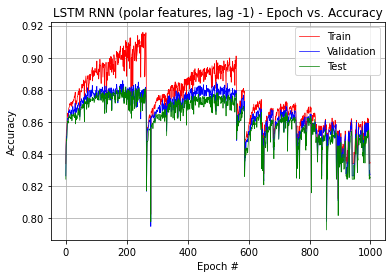

In [315]:
epochs = np.arange(0,num_epochs,1)

plt.plot(epochs, train_rnn, c="r", lw=0.7, label="Train")
plt.plot(epochs, val_rnn, c="b", lw=0.7, label="Validation")
plt.plot(epochs, test_rnn, c="g", lw=0.7, label="Test")
plt.grid(True)
plt.legend(loc="upper right")
plt.title(f"LSTM RNN ({features} features, lag {lag}) - Epoch vs. Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch #")

# Neural Net

In [119]:
from numpy import vstack
from pandas import read_csv
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch import Tensor
from torch.nn import Linear
from torch.nn import ReLU
from torch.nn import Sigmoid
from torch.nn import Module
from torch.optim import SGD
from torch.nn import BCELoss
from torch.nn.init import kaiming_uniform_
from torch.nn.init import xavier_uniform_

# model definition
class MLP(Module):
    # define model elements
    def __init__(self, n_inputs):
        super(MLP, self).__init__()
        # input to first hidden layer
        self.hidden1 = Linear(n_inputs, 600).to(device)
        kaiming_uniform_(self.hidden1.weight, nonlinearity='relu').to(device)
        self.act1 = ReLU()
        # second hidden layer
        self.hidden2 = Linear(600, 500).to(device)
        kaiming_uniform_(self.hidden2.weight, nonlinearity='relu').to(device)
        self.act2 = ReLU()
        # third hidden layer and output
        self.hidden3 = Linear(500, 300).to(device)
        kaiming_uniform_(self.hidden3.weight, nonlinearity='relu').to(device)
        self.act3 = ReLU()
        #
        self.hidden4 = Linear(300, 150).to(device)
        kaiming_uniform_(self.hidden4.weight, nonlinearity='relu').to(device)
        self.act4 = ReLU()
        #
        self.hidden5 = Linear(150, 1).to(device)
        xavier_uniform_(self.hidden5.weight).to(device)
        self.act5 = Sigmoid()
        
 
    # forward propagate input
    def forward(self, X):
        # input to first hidden layer
        X = self.hidden1(X)
        X = self.act1(X)
         # second hidden layer
        X = self.hidden2(X)
        X = self.act2(X)
        # third hidden layer and output
        X = self.hidden3(X)
        X = self.act3(X)
        #
        X = self.hidden4(X)
        X = self.act4(X)
        #
        X = self.hidden5(X)
        X = self.act5(X)
        return X

# train the model
def train_model(train_dl, model):
    # define the optimization
    criterion = BCELoss()
    optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)
    # enumerate epochs
    for epoch in tqdm(range(100)):
        # enumerate mini batches
        for i, (inputs, targets) in enumerate(train_dl):
            # clear the gradients
            optimizer.zero_grad()
            # compute the model output
            yhat = model(inputs.to(device))
            # calculate loss
            #print(yhat.shape)
            loss = criterion(yhat, targets.reshape(-1,1).to(device))
            print(f"epoch {i}: loss {loss}")
            # credit assignment
            loss.backward()
            # update model weights
            optimizer.step()

            
# evaluate the model
def evaluate_model(test_dl, model):
    predictions, actuals = list(), list()
    for i, (inputs, targets) in enumerate(test_dl):
        # evaluate the model on the test set
        yhat = model(inputs.to(device)).cpu()
        # retrieve numpy array
        yhat = yhat.detach().numpy()
        actual = targets.numpy()
        actual = actual.reshape((len(actual), 1))
        # round to class values
        yhat = yhat.round()
        # store
        predictions.append(yhat)
        actuals.append(actual)
    predictions, actuals = vstack(predictions), vstack(actuals)
    # calculate accuracy
    acc = accuracy_score(actuals, predictions)
    return acc
 
# make a class prediction for one row of data
def predict(row, model):
    # convert row to data
    row = Tensor([row])
    # make prediction
    yhat = model(row)
    # retrieve numpy array
    yhat = yhat.cpu().detach().numpy()
    return yhat
 
# define the network
model = MLP(784)
# train the model
train_model(train_iterator, model)
# evaluate the model
acc = evaluate_model(val_iterator, model)
print('Accuracy: %.3f' % acc)

  0%|          | 0/100 [00:00<?, ?it/s]

epoch 0: loss 0.5500611662864685
epoch 1: loss 0.4101846218109131
epoch 2: loss 0.5257068276405334
epoch 3: loss 0.6833233833312988
epoch 4: loss 0.45541390776634216
epoch 5: loss 0.3435070216655731
epoch 6: loss 0.40591639280319214
epoch 7: loss 0.38531774282455444
epoch 8: loss 0.474290132522583
epoch 9: loss 0.49090608954429626
epoch 10: loss 0.4676029086112976
epoch 11: loss 0.4214766025543213
epoch 12: loss 0.38312554359436035
epoch 13: loss 0.5094064474105835
epoch 14: loss 0.4004752039909363
epoch 15: loss 0.4089033007621765
epoch 16: loss 0.37904679775238037
epoch 17: loss 0.4463964104652405
epoch 18: loss 0.486097514629364
epoch 19: loss 0.3884008824825287
epoch 20: loss 0.4015762507915497
epoch 21: loss 0.3920731544494629
epoch 22: loss 0.4037277102470398
epoch 23: loss 0.45267534255981445
epoch 24: loss 0.40353846549987793
epoch 25: loss 0.46682465076446533
epoch 26: loss 0.4019089639186859
epoch 27: loss 0.4145364761352539
epoch 28: loss 0.5167216062545776
epoch 29: loss 0.

epoch 79: loss 0.36564406752586365
epoch 80: loss 0.39578962326049805
epoch 81: loss 0.2856045961380005
epoch 82: loss 0.352457731962204
epoch 83: loss 0.3973473310470581
epoch 84: loss 0.28241315484046936
epoch 85: loss 0.32330116629600525
epoch 86: loss 0.3842965364456177
epoch 87: loss 0.3445189595222473
epoch 88: loss 0.2811815142631531
epoch 89: loss 0.3566948175430298
epoch 90: loss 0.2664194703102112
epoch 91: loss 0.3694326877593994
epoch 92: loss 0.307528018951416
epoch 93: loss 0.3611753582954407
epoch 94: loss 0.3142728805541992
epoch 95: loss 0.21857795119285583
epoch 96: loss 0.2647843658924103
epoch 97: loss 0.3308212161064148
epoch 98: loss 0.31871142983436584
epoch 99: loss 0.38119810819625854
epoch 100: loss 0.4576214551925659
epoch 101: loss 0.3359769582748413
epoch 102: loss 0.2869722843170166
epoch 103: loss 0.3864065408706665
epoch 104: loss 0.2880285382270813
epoch 105: loss 0.3738902509212494
epoch 106: loss 0.3408002257347107
epoch 107: loss 0.3445669412612915
e

epoch 42: loss 0.2921815514564514
epoch 43: loss 0.31520894169807434
epoch 44: loss 0.38653764128685
epoch 45: loss 0.28789716958999634
epoch 46: loss 0.3416782021522522
epoch 47: loss 0.29677248001098633
epoch 48: loss 0.3119189739227295
epoch 49: loss 0.31638723611831665
epoch 50: loss 0.2827293276786804
epoch 51: loss 0.4402240812778473
epoch 52: loss 0.3160759210586548
epoch 53: loss 0.3820888102054596
epoch 54: loss 0.3428497910499573
epoch 55: loss 0.31732887029647827
epoch 56: loss 0.34542116522789
epoch 57: loss 0.24890020489692688
epoch 58: loss 0.37610310316085815
epoch 59: loss 0.25484123826026917
epoch 60: loss 0.3724595904350281
epoch 61: loss 0.22840319573879242
epoch 62: loss 0.2545928657054901
epoch 63: loss 0.3641064763069153
epoch 64: loss 0.32462894916534424
epoch 65: loss 0.4136999845504761
epoch 66: loss 0.3519056439399719
epoch 67: loss 0.38571780920028687
epoch 68: loss 0.37929767370224
epoch 69: loss 0.44690877199172974
epoch 70: loss 0.4054431915283203
epoch 71

epoch 122: loss 0.30957692861557007
epoch 123: loss 0.4008687138557434
epoch 124: loss 0.31477364897727966
epoch 125: loss 0.326911985874176
epoch 126: loss 0.38186103105545044
epoch 127: loss 0.41021907329559326
epoch 128: loss 0.2874417304992676
epoch 129: loss 0.3450600802898407
epoch 130: loss 0.3907572627067566
epoch 131: loss 0.34756436944007874
epoch 132: loss 0.3377028703689575
epoch 133: loss 0.3597000241279602
epoch 134: loss 0.32160767912864685
epoch 135: loss 0.26750439405441284
epoch 136: loss 0.23527756333351135
epoch 0: loss 0.4096202254295349
epoch 1: loss 0.3590545058250427
epoch 2: loss 0.4396924674510956
epoch 3: loss 0.3897557258605957
epoch 4: loss 0.37598875164985657
epoch 5: loss 0.3158378005027771
epoch 6: loss 0.2967967391014099
epoch 7: loss 0.2528761029243469
epoch 8: loss 0.4773944616317749
epoch 9: loss 0.49180179834365845
epoch 10: loss 0.3627208471298218
epoch 11: loss 0.30076172947883606
epoch 12: loss 0.39949530363082886
epoch 13: loss 0.445428997278213

epoch 66: loss 0.35878047347068787
epoch 67: loss 0.383865088224411
epoch 68: loss 0.36917734146118164
epoch 69: loss 0.43634361028671265
epoch 70: loss 0.4026485085487366
epoch 71: loss 0.3279463052749634
epoch 72: loss 0.2807009816169739
epoch 73: loss 0.34938398003578186
epoch 74: loss 0.2949312627315521
epoch 75: loss 0.32730820775032043
epoch 76: loss 0.30506432056427
epoch 77: loss 0.40783166885375977
epoch 78: loss 0.3141530752182007
epoch 79: loss 0.3510892391204834
epoch 80: loss 0.3814520239830017
epoch 81: loss 0.2918451726436615
epoch 82: loss 0.3371497690677643
epoch 83: loss 0.3890513479709625
epoch 84: loss 0.25096702575683594
epoch 85: loss 0.31883615255355835
epoch 86: loss 0.35447049140930176
epoch 87: loss 0.3448483347892761
epoch 88: loss 0.2713581323623657
epoch 89: loss 0.33416905999183655
epoch 90: loss 0.2576962113380432
epoch 91: loss 0.3346683382987976
epoch 92: loss 0.28420376777648926
epoch 93: loss 0.33894237875938416
epoch 94: loss 0.2988416254520416
epoch

epoch 8: loss 0.4445115327835083
epoch 9: loss 0.4810005724430084
epoch 10: loss 0.3670188784599304
epoch 11: loss 0.28895318508148193
epoch 12: loss 0.351140558719635
epoch 13: loss 0.4336097538471222
epoch 14: loss 0.36995428800582886
epoch 15: loss 0.31237104535102844
epoch 16: loss 0.33608192205429077
epoch 17: loss 0.36572685837745667
epoch 18: loss 0.42215844988822937
epoch 19: loss 0.2804291844367981
epoch 20: loss 0.30933836102485657
epoch 21: loss 0.3514232039451599
epoch 22: loss 0.3348492383956909
epoch 23: loss 0.38103047013282776
epoch 24: loss 0.3623407483100891
epoch 25: loss 0.3994485139846802
epoch 26: loss 0.3219192326068878
epoch 27: loss 0.35781627893447876
epoch 28: loss 0.4104622006416321
epoch 29: loss 0.3188140392303467
epoch 30: loss 0.2801325023174286
epoch 31: loss 0.33996719121932983
epoch 32: loss 0.34034180641174316
epoch 33: loss 0.3499835729598999
epoch 34: loss 0.3902769684791565
epoch 35: loss 0.2614765465259552
epoch 36: loss 0.338255912065506
epoch 3

epoch 87: loss 0.34567925333976746
epoch 88: loss 0.2673581838607788
epoch 89: loss 0.3278135359287262
epoch 90: loss 0.25941431522369385
epoch 91: loss 0.3291699290275574
epoch 92: loss 0.28328847885131836
epoch 93: loss 0.3344647288322449
epoch 94: loss 0.29377153515815735
epoch 95: loss 0.19288620352745056
epoch 96: loss 0.23204563558101654
epoch 97: loss 0.3169374167919159
epoch 98: loss 0.33805811405181885
epoch 99: loss 0.36979299783706665
epoch 100: loss 0.46400195360183716
epoch 101: loss 0.39490655064582825
epoch 102: loss 0.28264981508255005
epoch 103: loss 0.3159555196762085
epoch 104: loss 0.26979291439056396
epoch 105: loss 0.39391815662384033
epoch 106: loss 0.37200799584388733
epoch 107: loss 0.3169001340866089
epoch 108: loss 0.35039204359054565
epoch 109: loss 0.3673100769519806
epoch 110: loss 0.35470709204673767
epoch 111: loss 0.38411325216293335
epoch 112: loss 0.38238024711608887
epoch 113: loss 0.32737112045288086
epoch 114: loss 0.2335130274295807
epoch 115: los

epoch 28: loss 0.39779698848724365
epoch 29: loss 0.32037100195884705
epoch 30: loss 0.27810409665107727
epoch 31: loss 0.3408336043357849
epoch 32: loss 0.337309330701828
epoch 33: loss 0.3489130437374115
epoch 34: loss 0.3911672532558441
epoch 35: loss 0.25483036041259766
epoch 36: loss 0.33383822441101074
epoch 37: loss 0.32158565521240234
epoch 38: loss 0.21717675030231476
epoch 39: loss 0.3200816512107849
epoch 40: loss 0.3095448613166809
epoch 41: loss 0.28923892974853516
epoch 42: loss 0.2897073030471802
epoch 43: loss 0.31436794996261597
epoch 44: loss 0.36768415570259094
epoch 45: loss 0.289997398853302
epoch 46: loss 0.3427899479866028
epoch 47: loss 0.29012542963027954
epoch 48: loss 0.26996538043022156
epoch 49: loss 0.3441578149795532
epoch 50: loss 0.29834678769111633
epoch 51: loss 0.4164915978908539
epoch 52: loss 0.3034587502479553
epoch 53: loss 0.3713076412677765
epoch 54: loss 0.33282721042633057
epoch 55: loss 0.30338814854621887
epoch 56: loss 0.34713536500930786


epoch 128: loss 0.2829509377479553
epoch 129: loss 0.3435678482055664
epoch 130: loss 0.37691086530685425
epoch 131: loss 0.32390499114990234
epoch 132: loss 0.32012510299682617
epoch 133: loss 0.3572903275489807
epoch 134: loss 0.3211645483970642
epoch 135: loss 0.26276931166648865
epoch 136: loss 0.237234428524971
epoch 0: loss 0.36934638023376465
epoch 1: loss 0.34156158566474915
epoch 2: loss 0.4239214360713959
epoch 3: loss 0.3734096884727478
epoch 4: loss 0.3486114740371704
epoch 5: loss 0.269620805978775
epoch 6: loss 0.29018881916999817
epoch 7: loss 0.23794269561767578
epoch 8: loss 0.4511041045188904
epoch 9: loss 0.47254064679145813
epoch 10: loss 0.33845341205596924
epoch 11: loss 0.28317585587501526
epoch 12: loss 0.3916762173175812
epoch 13: loss 0.4461153745651245
epoch 14: loss 0.3556770384311676
epoch 15: loss 0.3273780345916748
epoch 16: loss 0.37293457984924316
epoch 17: loss 0.4011693596839905
epoch 18: loss 0.41635245084762573
epoch 19: loss 0.281013548374176
epoch

epoch 53: loss 0.36675208806991577
epoch 54: loss 0.3363795876502991
epoch 55: loss 0.3043982982635498
epoch 56: loss 0.35795700550079346
epoch 57: loss 0.2451597899198532
epoch 58: loss 0.363217830657959
epoch 59: loss 0.2576349675655365
epoch 60: loss 0.3546989858150482
epoch 61: loss 0.22259864211082458
epoch 62: loss 0.24126508831977844
epoch 63: loss 0.3468225300312042
epoch 64: loss 0.31038177013397217
epoch 65: loss 0.3973197340965271
epoch 66: loss 0.3345717191696167
epoch 67: loss 0.3744947016239166
epoch 68: loss 0.36759036779403687
epoch 69: loss 0.43704652786254883
epoch 70: loss 0.40029454231262207
epoch 71: loss 0.31904128193855286
epoch 72: loss 0.27815574407577515
epoch 73: loss 0.33593547344207764
epoch 74: loss 0.28935006260871887
epoch 75: loss 0.3292589783668518
epoch 76: loss 0.3063817620277405
epoch 77: loss 0.39729952812194824
epoch 78: loss 0.3125033378601074
epoch 79: loss 0.358177125453949
epoch 80: loss 0.3871462643146515
epoch 81: loss 0.26909583806991577
ep

epoch 124: loss 0.3059365451335907
epoch 125: loss 0.3299711346626282
epoch 126: loss 0.36326873302459717
epoch 127: loss 0.37814706563949585
epoch 128: loss 0.2986811101436615
epoch 129: loss 0.3479200005531311
epoch 130: loss 0.3714503049850464
epoch 131: loss 0.32038915157318115
epoch 132: loss 0.3194490671157837
epoch 133: loss 0.3607443869113922
epoch 134: loss 0.3211700916290283
epoch 135: loss 0.2567511796951294
epoch 136: loss 0.24010874330997467
epoch 0: loss 0.35392042994499207
epoch 1: loss 0.33634886145591736
epoch 2: loss 0.3937298357486725
epoch 3: loss 0.3795315623283386
epoch 4: loss 0.3253854811191559
epoch 5: loss 0.26276296377182007
epoch 6: loss 0.289714515209198
epoch 7: loss 0.23107436299324036
epoch 8: loss 0.43028128147125244
epoch 9: loss 0.44739818572998047
epoch 10: loss 0.3358626961708069
epoch 11: loss 0.2757834494113922
epoch 12: loss 0.36867856979370117
epoch 13: loss 0.4363040328025818
epoch 14: loss 0.3411861062049866
epoch 15: loss 0.3022555112838745
e

epoch 44: loss 0.34453344345092773
epoch 45: loss 0.2779581844806671
epoch 46: loss 0.29379844665527344
epoch 47: loss 0.278336763381958
epoch 48: loss 0.2560812830924988
epoch 49: loss 0.33073896169662476
epoch 50: loss 0.28643810749053955
epoch 51: loss 0.4294721484184265
epoch 52: loss 0.3003113269805908
epoch 53: loss 0.3705654740333557
epoch 54: loss 0.34852439165115356
epoch 55: loss 0.3016382157802582
epoch 56: loss 0.3531770408153534
epoch 57: loss 0.2574208378791809
epoch 58: loss 0.33124327659606934
epoch 59: loss 0.24996882677078247
epoch 60: loss 0.3420765995979309
epoch 61: loss 0.22222954034805298
epoch 62: loss 0.23748819530010223
epoch 63: loss 0.3703973591327667
epoch 64: loss 0.3000366985797882
epoch 65: loss 0.400296688079834
epoch 66: loss 0.33951160311698914
epoch 67: loss 0.3799762725830078
epoch 68: loss 0.36982470750808716
epoch 69: loss 0.4218781292438507
epoch 70: loss 0.3895031809806824
epoch 71: loss 0.3090566098690033
epoch 72: loss 0.2615852653980255
epoch

epoch 106: loss 0.3211989998817444
epoch 107: loss 0.2912852168083191
epoch 108: loss 0.3501991033554077
epoch 109: loss 0.36761200428009033
epoch 110: loss 0.3589288592338562
epoch 111: loss 0.3900170624256134
epoch 112: loss 0.3894140422344208
epoch 113: loss 0.3039039075374603
epoch 114: loss 0.19651943445205688
epoch 115: loss 0.39377012848854065
epoch 116: loss 0.3351152241230011
epoch 117: loss 0.2804480791091919
epoch 118: loss 0.32715606689453125
epoch 119: loss 0.37233003973960876
epoch 120: loss 0.29095810651779175
epoch 121: loss 0.41371119022369385
epoch 122: loss 0.2717219293117523
epoch 123: loss 0.41609668731689453
epoch 124: loss 0.314349502325058
epoch 125: loss 0.3183843493461609
epoch 126: loss 0.36403143405914307
epoch 127: loss 0.3841734528541565
epoch 128: loss 0.28223907947540283
epoch 129: loss 0.3506276607513428
epoch 130: loss 0.3660022020339966
epoch 131: loss 0.32768094539642334
epoch 132: loss 0.3159340023994446
epoch 133: loss 0.35715150833129883
epoch 134

epoch 41: loss 0.28222233057022095
epoch 42: loss 0.2630782127380371
epoch 43: loss 0.32374608516693115
epoch 44: loss 0.34066933393478394
epoch 45: loss 0.2777637541294098
epoch 46: loss 0.2916315793991089
epoch 47: loss 0.27922165393829346
epoch 48: loss 0.2527204751968384
epoch 49: loss 0.3355211615562439
epoch 50: loss 0.2881992757320404
epoch 51: loss 0.42687079310417175
epoch 52: loss 0.297009140253067
epoch 53: loss 0.368549644947052
epoch 54: loss 0.3486844301223755
epoch 55: loss 0.29996711015701294
epoch 56: loss 0.354648619890213
epoch 57: loss 0.25429970026016235
epoch 58: loss 0.32721957564353943
epoch 59: loss 0.25539278984069824
epoch 60: loss 0.3375166654586792
epoch 61: loss 0.22566655278205872
epoch 62: loss 0.24189971387386322
epoch 63: loss 0.3693583905696869
epoch 64: loss 0.29864415526390076
epoch 65: loss 0.4014045298099518
epoch 66: loss 0.33382850885391235
epoch 67: loss 0.37618860602378845
epoch 68: loss 0.37392497062683105
epoch 69: loss 0.4172070026397705
ep

epoch 115: loss 0.4302626848220825
epoch 116: loss 0.3054974377155304
epoch 117: loss 0.27256351709365845
epoch 118: loss 0.3328639268875122
epoch 119: loss 0.3680138885974884
epoch 120: loss 0.28211045265197754
epoch 121: loss 0.38130560517311096
epoch 122: loss 0.2610894739627838
epoch 123: loss 0.3931502103805542
epoch 124: loss 0.3079255521297455
epoch 125: loss 0.33700183033943176
epoch 126: loss 0.36277762055397034
epoch 127: loss 0.37711024284362793
epoch 128: loss 0.28943759202957153
epoch 129: loss 0.34801730513572693
epoch 130: loss 0.3695262670516968
epoch 131: loss 0.3151152729988098
epoch 132: loss 0.31315648555755615
epoch 133: loss 0.3549252152442932
epoch 134: loss 0.3224891126155853
epoch 135: loss 0.26696667075157166
epoch 136: loss 0.24544405937194824
epoch 0: loss 0.36566999554634094
epoch 1: loss 0.339180588722229
epoch 2: loss 0.4361017346382141
epoch 3: loss 0.3684803545475006
epoch 4: loss 0.3388885259628296
epoch 5: loss 0.2795562148094177
epoch 6: loss 0.28600

epoch 56: loss 0.3538740277290344
epoch 57: loss 0.25976675748825073
epoch 58: loss 0.32798922061920166
epoch 59: loss 0.26173561811447144
epoch 60: loss 0.33326804637908936
epoch 61: loss 0.225686714053154
epoch 62: loss 0.24215158820152283
epoch 63: loss 0.3642202913761139
epoch 64: loss 0.30308306217193604
epoch 65: loss 0.4056016802787781
epoch 66: loss 0.32846784591674805
epoch 67: loss 0.37003329396247864
epoch 68: loss 0.36372631788253784
epoch 69: loss 0.4062636196613312
epoch 70: loss 0.38596081733703613
epoch 71: loss 0.32461267709732056
epoch 72: loss 0.25926870107650757
epoch 73: loss 0.3398933410644531
epoch 74: loss 0.2897459864616394
epoch 75: loss 0.3362184166908264
epoch 76: loss 0.302142858505249
epoch 77: loss 0.4101652503013611
epoch 78: loss 0.3096039891242981
epoch 79: loss 0.35979828238487244
epoch 80: loss 0.37895309925079346
epoch 81: loss 0.27226173877716064
epoch 82: loss 0.35316699743270874
epoch 83: loss 0.37891513109207153
epoch 84: loss 0.2496895492076873

epoch 134: loss 0.32658061385154724
epoch 135: loss 0.25319433212280273
epoch 136: loss 0.23851247131824493
epoch 0: loss 0.35439932346343994
epoch 1: loss 0.3318634033203125
epoch 2: loss 0.3901510238647461
epoch 3: loss 0.37384557723999023
epoch 4: loss 0.3316376507282257
epoch 5: loss 0.25914227962493896
epoch 6: loss 0.28443998098373413
epoch 7: loss 0.22489118576049805
epoch 8: loss 0.4251505136489868
epoch 9: loss 0.4451013505458832
epoch 10: loss 0.3522043824195862
epoch 11: loss 0.28206199407577515
epoch 12: loss 0.30853062868118286
epoch 13: loss 0.4076142907142639
epoch 14: loss 0.4184989929199219
epoch 15: loss 0.2823582589626312
epoch 16: loss 0.3413568139076233
epoch 17: loss 0.36741435527801514
epoch 18: loss 0.4269894063472748
epoch 19: loss 0.29837942123413086
epoch 20: loss 0.3284135162830353
epoch 21: loss 0.3612387478351593
epoch 22: loss 0.3257681429386139
epoch 23: loss 0.3728792667388916
epoch 24: loss 0.3423202633857727
epoch 25: loss 0.4163846969604492
epoch 26:

epoch 71: loss 0.32766878604888916
epoch 72: loss 0.2564900517463684
epoch 73: loss 0.3308102488517761
epoch 74: loss 0.2791861295700073
epoch 75: loss 0.33964449167251587
epoch 76: loss 0.3032068610191345
epoch 77: loss 0.4071635603904724
epoch 78: loss 0.30679914355278015
epoch 79: loss 0.35717231035232544
epoch 80: loss 0.37998247146606445
epoch 81: loss 0.2654266655445099
epoch 82: loss 0.3356899321079254
epoch 83: loss 0.38972949981689453
epoch 84: loss 0.2508071959018707
epoch 85: loss 0.2997514605522156
epoch 86: loss 0.3391880691051483
epoch 87: loss 0.3440726399421692
epoch 88: loss 0.2657005786895752
epoch 89: loss 0.35347384214401245
epoch 90: loss 0.2993990182876587
epoch 91: loss 0.35853251814842224
epoch 92: loss 0.30215930938720703
epoch 93: loss 0.3106911778450012
epoch 94: loss 0.2976562976837158
epoch 95: loss 0.25704696774482727
epoch 96: loss 0.21374602615833282
epoch 97: loss 0.2902225852012634
epoch 98: loss 0.3158816695213318
epoch 99: loss 0.3701479434967041
epo

epoch 10: loss 0.36007624864578247
epoch 11: loss 0.28994834423065186
epoch 12: loss 0.30584585666656494
epoch 13: loss 0.42786115407943726
epoch 14: loss 0.368476927280426
epoch 15: loss 0.2947118878364563
epoch 16: loss 0.36506134271621704
epoch 17: loss 0.3343546986579895
epoch 18: loss 0.37728607654571533
epoch 19: loss 0.2626453638076782
epoch 20: loss 0.3025375008583069
epoch 21: loss 0.335965633392334
epoch 22: loss 0.31954365968704224
epoch 23: loss 0.3722144067287445
epoch 24: loss 0.34290602803230286
epoch 25: loss 0.4032787084579468
epoch 26: loss 0.35334527492523193
epoch 27: loss 0.3396647274494171
epoch 28: loss 0.4069865345954895
epoch 29: loss 0.31741583347320557
epoch 30: loss 0.2892848253250122
epoch 31: loss 0.3366710841655731
epoch 32: loss 0.3520079255104065
epoch 33: loss 0.3363686800003052
epoch 34: loss 0.3836732506752014
epoch 35: loss 0.2585662007331848
epoch 36: loss 0.32320213317871094
epoch 37: loss 0.32498878240585327
epoch 38: loss 0.22556713223457336
epo

epoch 88: loss 0.2720802128314972
epoch 89: loss 0.37544283270835876
epoch 90: loss 0.3197101056575775
epoch 91: loss 0.4356890022754669
epoch 92: loss 0.3430621027946472
epoch 93: loss 0.31448933482170105
epoch 94: loss 0.2949090003967285
epoch 95: loss 0.26787179708480835
epoch 96: loss 0.24846044182777405
epoch 97: loss 0.2971915900707245
epoch 98: loss 0.3125196695327759
epoch 99: loss 0.36129045486450195
epoch 100: loss 0.48979872465133667
epoch 101: loss 0.30886539816856384
epoch 102: loss 0.2704884111881256
epoch 103: loss 0.3317188620567322
epoch 104: loss 0.26078516244888306
epoch 105: loss 0.376644492149353
epoch 106: loss 0.3164857029914856
epoch 107: loss 0.2791290581226349
epoch 108: loss 0.36226004362106323
epoch 109: loss 0.35837578773498535
epoch 110: loss 0.3493829667568207
epoch 111: loss 0.36424610018730164
epoch 112: loss 0.36720332503318787
epoch 113: loss 0.2767902612686157
epoch 114: loss 0.1643429398536682
epoch 115: loss 0.4018046259880066
epoch 116: loss 0.295

epoch 28: loss 0.39500874280929565
epoch 29: loss 0.3187498152256012
epoch 30: loss 0.2912254333496094
epoch 31: loss 0.3317170739173889
epoch 32: loss 0.3431183397769928
epoch 33: loss 0.33981895446777344
epoch 34: loss 0.3805761933326721
epoch 35: loss 0.2583531439304352
epoch 36: loss 0.3269386887550354
epoch 37: loss 0.32295623421669006
epoch 38: loss 0.2285698652267456
epoch 39: loss 0.3145425319671631
epoch 40: loss 0.30731743574142456
epoch 41: loss 0.27899640798568726
epoch 42: loss 0.24898648262023926
epoch 43: loss 0.3312680125236511
epoch 44: loss 0.33386415243148804
epoch 45: loss 0.27291902899742126
epoch 46: loss 0.2893338203430176
epoch 47: loss 0.27936601638793945
epoch 48: loss 0.2525605261325836
epoch 49: loss 0.33670222759246826
epoch 50: loss 0.2800825834274292
epoch 51: loss 0.4186728298664093
epoch 52: loss 0.29410916566848755
epoch 53: loss 0.3743478059768677
epoch 54: loss 0.3474254012107849
epoch 55: loss 0.30255287885665894
epoch 56: loss 0.3466782569885254
ep

epoch 103: loss 0.32469677925109863
epoch 104: loss 0.2594423294067383
epoch 105: loss 0.3786991834640503
epoch 106: loss 0.3144916296005249
epoch 107: loss 0.26945239305496216
epoch 108: loss 0.3487488031387329
epoch 109: loss 0.35912948846817017
epoch 110: loss 0.3429388999938965
epoch 111: loss 0.3762739896774292
epoch 112: loss 0.36604875326156616
epoch 113: loss 0.27932727336883545
epoch 114: loss 0.16472649574279785
epoch 115: loss 0.4042063355445862
epoch 116: loss 0.294323205947876
epoch 117: loss 0.25992676615715027
epoch 118: loss 0.3185179829597473
epoch 119: loss 0.38715660572052
epoch 120: loss 0.26840293407440186
epoch 121: loss 0.35427433252334595
epoch 122: loss 0.24284479022026062
epoch 123: loss 0.386465847492218
epoch 124: loss 0.30028778314590454
epoch 125: loss 0.33562085032463074
epoch 126: loss 0.35476312041282654
epoch 127: loss 0.3786686062812805
epoch 128: loss 0.264026939868927
epoch 129: loss 0.3396603763103485
epoch 130: loss 0.36423739790916443
epoch 131: 

epoch 42: loss 0.26023560762405396
epoch 43: loss 0.3322659134864807
epoch 44: loss 0.33243003487586975
epoch 45: loss 0.2768031656742096
epoch 46: loss 0.2839100956916809
epoch 47: loss 0.2807092070579529
epoch 48: loss 0.2437150478363037
epoch 49: loss 0.33423489332199097
epoch 50: loss 0.2858967185020447
epoch 51: loss 0.41472381353378296
epoch 52: loss 0.2888224124908447
epoch 53: loss 0.3628762364387512
epoch 54: loss 0.3486204743385315
epoch 55: loss 0.29578518867492676
epoch 56: loss 0.35135817527770996
epoch 57: loss 0.24535444378852844
epoch 58: loss 0.32242700457572937
epoch 59: loss 0.26252174377441406
epoch 60: loss 0.32450157403945923
epoch 61: loss 0.22129356861114502
epoch 62: loss 0.24267132580280304
epoch 63: loss 0.3428137004375458
epoch 64: loss 0.28382015228271484
epoch 65: loss 0.3971724510192871
epoch 66: loss 0.32827433943748474
epoch 67: loss 0.37049371004104614
epoch 68: loss 0.3566201329231262
epoch 69: loss 0.40475571155548096
epoch 70: loss 0.393467843532562

epoch 119: loss 0.3958311080932617
epoch 120: loss 0.26779037714004517
epoch 121: loss 0.3549817204475403
epoch 122: loss 0.23806798458099365
epoch 123: loss 0.3853367567062378
epoch 124: loss 0.30112555623054504
epoch 125: loss 0.33307403326034546
epoch 126: loss 0.3555159866809845
epoch 127: loss 0.3763997554779053
epoch 128: loss 0.26240074634552
epoch 129: loss 0.33623069524765015
epoch 130: loss 0.3617890477180481
epoch 131: loss 0.31984177231788635
epoch 132: loss 0.31883853673934937
epoch 133: loss 0.3463919162750244
epoch 134: loss 0.3073921799659729
epoch 135: loss 0.24550306797027588
epoch 136: loss 0.22249804437160492
epoch 0: loss 0.3326514959335327
epoch 1: loss 0.3335171043872833
epoch 2: loss 0.3718357980251312
epoch 3: loss 0.36087214946746826
epoch 4: loss 0.3147544264793396
epoch 5: loss 0.24715012311935425
epoch 6: loss 0.27570611238479614
epoch 7: loss 0.22053591907024384
epoch 8: loss 0.4266131520271301
epoch 9: loss 0.43623751401901245
epoch 10: loss 0.34644603729

epoch 55: loss 0.304751455783844
epoch 56: loss 0.3448045551776886
epoch 57: loss 0.24291740357875824
epoch 58: loss 0.32177621126174927
epoch 59: loss 0.2663559317588806
epoch 60: loss 0.32813772559165955
epoch 61: loss 0.22250738739967346
epoch 62: loss 0.24045942723751068
epoch 63: loss 0.3350575566291809
epoch 64: loss 0.2819483280181885
epoch 65: loss 0.3868187665939331
epoch 66: loss 0.3281022906303406
epoch 67: loss 0.3780256509780884
epoch 68: loss 0.3559485971927643
epoch 69: loss 0.4217475652694702
epoch 70: loss 0.37403765320777893
epoch 71: loss 0.31613457202911377
epoch 72: loss 0.26028281450271606
epoch 73: loss 0.31818023324012756
epoch 74: loss 0.262311190366745
epoch 75: loss 0.33738526701927185
epoch 76: loss 0.31200718879699707
epoch 77: loss 0.3956218361854553
epoch 78: loss 0.3121962547302246
epoch 79: loss 0.31414681673049927
epoch 80: loss 0.380235493183136
epoch 81: loss 0.26914143562316895
epoch 82: loss 0.3342747092247009
epoch 83: loss 0.3770514130592346
epoc

epoch 130: loss 0.3650912046432495
epoch 131: loss 0.3179527521133423
epoch 132: loss 0.3117029070854187
epoch 133: loss 0.3456611633300781
epoch 134: loss 0.31709396839141846
epoch 135: loss 0.26654496788978577
epoch 136: loss 0.2506864666938782
epoch 0: loss 0.3420323133468628
epoch 1: loss 0.32391050457954407
epoch 2: loss 0.40122196078300476
epoch 3: loss 0.3464887738227844
epoch 4: loss 0.2981299161911011
epoch 5: loss 0.262371689081192
epoch 6: loss 0.27427899837493896
epoch 7: loss 0.21600210666656494
epoch 8: loss 0.40162062644958496
epoch 9: loss 0.398640513420105
epoch 10: loss 0.3289870619773865
epoch 11: loss 0.2765974700450897
epoch 12: loss 0.29651057720184326
epoch 13: loss 0.42668813467025757
epoch 14: loss 0.3396565020084381
epoch 15: loss 0.27491337060928345
epoch 16: loss 0.34163928031921387
epoch 17: loss 0.33349186182022095
epoch 18: loss 0.3654872179031372
epoch 19: loss 0.27515488862991333
epoch 20: loss 0.29047027230262756
epoch 21: loss 0.33116933703422546
epoc

epoch 75: loss 0.34533581137657166
epoch 76: loss 0.30596277117729187
epoch 77: loss 0.400729775428772
epoch 78: loss 0.3022969961166382
epoch 79: loss 0.3293028473854065
epoch 80: loss 0.379316508769989
epoch 81: loss 0.26617714762687683
epoch 82: loss 0.31128832697868347
epoch 83: loss 0.3903157114982605
epoch 84: loss 0.2559537887573242
epoch 85: loss 0.2953408360481262
epoch 86: loss 0.33620738983154297
epoch 87: loss 0.3382081389427185
epoch 88: loss 0.27262818813323975
epoch 89: loss 0.35897278785705566
epoch 90: loss 0.30450013279914856
epoch 91: loss 0.40170401334762573
epoch 92: loss 0.36341625452041626
epoch 93: loss 0.310494989156723
epoch 94: loss 0.2942112386226654
epoch 95: loss 0.1962691843509674
epoch 96: loss 0.2311319261789322
epoch 97: loss 0.31362050771713257
epoch 98: loss 0.32568156719207764
epoch 99: loss 0.32676464319229126
epoch 100: loss 0.45859140157699585
epoch 101: loss 0.2994562089443207
epoch 102: loss 0.2490890920162201
epoch 103: loss 0.2994835674762726

epoch 40: loss 0.30515965819358826
epoch 41: loss 0.2799372971057892
epoch 42: loss 0.24277307093143463
epoch 43: loss 0.331327348947525
epoch 44: loss 0.3322764039039612
epoch 45: loss 0.2773764133453369
epoch 46: loss 0.28191858530044556
epoch 47: loss 0.2810555100440979
epoch 48: loss 0.2416004091501236
epoch 49: loss 0.32432299852371216
epoch 50: loss 0.2804466485977173
epoch 51: loss 0.4075452983379364
epoch 52: loss 0.2946244776248932
epoch 53: loss 0.35902947187423706
epoch 54: loss 0.3434126377105713
epoch 55: loss 0.30010849237442017
epoch 56: loss 0.3428102433681488
epoch 57: loss 0.23840215802192688
epoch 58: loss 0.31887340545654297
epoch 59: loss 0.2661454677581787
epoch 60: loss 0.32099443674087524
epoch 61: loss 0.21475011110305786
epoch 62: loss 0.23711323738098145
epoch 63: loss 0.33044010400772095
epoch 64: loss 0.2741336226463318
epoch 65: loss 0.38635414838790894
epoch 66: loss 0.32406121492385864
epoch 67: loss 0.38033145666122437
epoch 68: loss 0.3555970788002014


epoch 121: loss 0.36712971329689026
epoch 122: loss 0.23434197902679443
epoch 123: loss 0.3767397999763489
epoch 124: loss 0.3201954960823059
epoch 125: loss 0.34190595149993896
epoch 126: loss 0.377008855342865
epoch 127: loss 0.4219154119491577
epoch 128: loss 0.2759777307510376
epoch 129: loss 0.35271650552749634
epoch 130: loss 0.36884504556655884
epoch 131: loss 0.3171008825302124
epoch 132: loss 0.31421971321105957
epoch 133: loss 0.3483296036720276
epoch 134: loss 0.31060582399368286
epoch 135: loss 0.2541762590408325
epoch 136: loss 0.23035721480846405
epoch 0: loss 0.3476243019104004
epoch 1: loss 0.32462209463119507
epoch 2: loss 0.4167634844779968
epoch 3: loss 0.3492060601711273
epoch 4: loss 0.2952440679073334
epoch 5: loss 0.25686582922935486
epoch 6: loss 0.2772396504878998
epoch 7: loss 0.23018822073936462
epoch 8: loss 0.39722317457199097
epoch 9: loss 0.3984944224357605
epoch 10: loss 0.33266130089759827
epoch 11: loss 0.2830193042755127
epoch 12: loss 0.2944920063018

epoch 63: loss 0.3322314918041229
epoch 64: loss 0.27831876277923584
epoch 65: loss 0.38879963755607605
epoch 66: loss 0.32472336292266846
epoch 67: loss 0.3759390115737915
epoch 68: loss 0.35459205508232117
epoch 69: loss 0.4126867651939392
epoch 70: loss 0.368717759847641
epoch 71: loss 0.3238111138343811
epoch 72: loss 0.24880225956439972
epoch 73: loss 0.31679385900497437
epoch 74: loss 0.26321834325790405
epoch 75: loss 0.34694617986679077
epoch 76: loss 0.30712175369262695
epoch 77: loss 0.4050050973892212
epoch 78: loss 0.304379403591156
epoch 79: loss 0.33133065700531006
epoch 80: loss 0.3764028549194336
epoch 81: loss 0.2668599784374237
epoch 82: loss 0.3142870366573334
epoch 83: loss 0.3921254873275757
epoch 84: loss 0.26220476627349854
epoch 85: loss 0.2935798168182373
epoch 86: loss 0.3379501700401306
epoch 87: loss 0.3354632258415222
epoch 88: loss 0.2794652581214905
epoch 89: loss 0.36500728130340576
epoch 90: loss 0.31156259775161743
epoch 91: loss 0.4190683662891388
epo

epoch 28: loss 0.4029466509819031
epoch 29: loss 0.3149615526199341
epoch 30: loss 0.2933858036994934
epoch 31: loss 0.33078351616859436
epoch 32: loss 0.3409712612628937
epoch 33: loss 0.3365594148635864
epoch 34: loss 0.3817010223865509
epoch 35: loss 0.25845277309417725
epoch 36: loss 0.32574462890625
epoch 37: loss 0.3195406198501587
epoch 38: loss 0.21766939759254456
epoch 39: loss 0.3052900433540344
epoch 40: loss 0.29915565252304077
epoch 41: loss 0.2805187404155731
epoch 42: loss 0.250845730304718
epoch 43: loss 0.33302509784698486
epoch 44: loss 0.32685333490371704
epoch 45: loss 0.2781293988227844
epoch 46: loss 0.2861255407333374
epoch 47: loss 0.2815350890159607
epoch 48: loss 0.24140620231628418
epoch 49: loss 0.32258355617523193
epoch 50: loss 0.2829509377479553
epoch 51: loss 0.4006611704826355
epoch 52: loss 0.2936861515045166
epoch 53: loss 0.35659629106521606
epoch 54: loss 0.3478250503540039
epoch 55: loss 0.3021070957183838
epoch 56: loss 0.34423360228538513
epoch 5

epoch 130: loss 0.36005353927612305
epoch 131: loss 0.316286563873291
epoch 132: loss 0.30837100744247437
epoch 133: loss 0.33926916122436523
epoch 134: loss 0.30764591693878174
epoch 135: loss 0.24225112795829773
epoch 136: loss 0.2260817289352417
epoch 0: loss 0.3268429934978485
epoch 1: loss 0.340197890996933
epoch 2: loss 0.36356011033058167
epoch 3: loss 0.35323119163513184
epoch 4: loss 0.29881420731544495
epoch 5: loss 0.24335384368896484
epoch 6: loss 0.27171021699905396
epoch 7: loss 0.211988627910614
epoch 8: loss 0.41381022334098816
epoch 9: loss 0.40501099824905396
epoch 10: loss 0.30982688069343567
epoch 11: loss 0.25851932168006897
epoch 12: loss 0.3134726285934448
epoch 13: loss 0.4193427264690399
epoch 14: loss 0.3382640480995178
epoch 15: loss 0.261152982711792
epoch 16: loss 0.3470063805580139
epoch 17: loss 0.33057647943496704
epoch 18: loss 0.3702359199523926
epoch 19: loss 0.2536100149154663
epoch 20: loss 0.2862998843193054
epoch 21: loss 0.33203327655792236
epoch

epoch 70: loss 0.3707268238067627
epoch 71: loss 0.30392444133758545
epoch 72: loss 0.24927294254302979
epoch 73: loss 0.3151649832725525
epoch 74: loss 0.25019219517707825
epoch 75: loss 0.34039878845214844
epoch 76: loss 0.3132723569869995
epoch 77: loss 0.39066746830940247
epoch 78: loss 0.3163890242576599
epoch 79: loss 0.30371785163879395
epoch 80: loss 0.36597979068756104
epoch 81: loss 0.2627801299095154
epoch 82: loss 0.3167411684989929
epoch 83: loss 0.3637023866176605
epoch 84: loss 0.2719128727912903
epoch 85: loss 0.293847918510437
epoch 86: loss 0.33088934421539307
epoch 87: loss 0.34015634655952454
epoch 88: loss 0.27121180295944214
epoch 89: loss 0.3329894542694092
epoch 90: loss 0.29468196630477905
epoch 91: loss 0.38555169105529785
epoch 92: loss 0.3531973659992218
epoch 93: loss 0.3047012388706207
epoch 94: loss 0.2935105264186859
epoch 95: loss 0.19847510755062103
epoch 96: loss 0.2403775006532669
epoch 97: loss 0.29097992181777954
epoch 98: loss 0.3159899115562439
e

epoch 9: loss 0.428519606590271
epoch 10: loss 0.3453025221824646
epoch 11: loss 0.28022071719169617
epoch 12: loss 0.3172633647918701
epoch 13: loss 0.41202884912490845
epoch 14: loss 0.3672657310962677
epoch 15: loss 0.2699914574623108
epoch 16: loss 0.3531573414802551
epoch 17: loss 0.36889344453811646
epoch 18: loss 0.41130369901657104
epoch 19: loss 0.274050772190094
epoch 20: loss 0.30626529455184937
epoch 21: loss 0.331628680229187
epoch 22: loss 0.3009895980358124
epoch 23: loss 0.3681856393814087
epoch 24: loss 0.3336835503578186
epoch 25: loss 0.3812679946422577
epoch 26: loss 0.3063371181488037
epoch 27: loss 0.34951046109199524
epoch 28: loss 0.40456095337867737
epoch 29: loss 0.317969411611557
epoch 30: loss 0.2909688353538513
epoch 31: loss 0.33157894015312195
epoch 32: loss 0.3380376994609833
epoch 33: loss 0.3428182005882263
epoch 34: loss 0.38537973165512085
epoch 35: loss 0.26013249158859253
epoch 36: loss 0.33075112104415894
epoch 37: loss 0.3086417019367218
epoch 38

epoch 91: loss 0.4368284344673157
epoch 92: loss 0.37822452187538147
epoch 93: loss 0.3101873993873596
epoch 94: loss 0.2851082384586334
epoch 95: loss 0.2193281054496765
epoch 96: loss 0.27396446466445923
epoch 97: loss 0.29759952425956726
epoch 98: loss 0.3105901777744293
epoch 99: loss 0.3435211777687073
epoch 100: loss 0.4714413285255432
epoch 101: loss 0.3053668737411499
epoch 102: loss 0.26418358087539673
epoch 103: loss 0.3266269266605377
epoch 104: loss 0.2565106749534607
epoch 105: loss 0.3691854476928711
epoch 106: loss 0.31533777713775635
epoch 107: loss 0.27564916014671326
epoch 108: loss 0.3579578399658203
epoch 109: loss 0.3502829968929291
epoch 110: loss 0.3430691063404083
epoch 111: loss 0.359334260225296
epoch 112: loss 0.3629423975944519
epoch 113: loss 0.27239567041397095
epoch 114: loss 0.16123037040233612
epoch 115: loss 0.3946608304977417
epoch 116: loss 0.2856481671333313
epoch 117: loss 0.2504405677318573
epoch 118: loss 0.3168705105781555
epoch 119: loss 0.3884

epoch 55: loss 0.29561877250671387
epoch 56: loss 0.35041552782058716
epoch 57: loss 0.2471565306186676
epoch 58: loss 0.31737810373306274
epoch 59: loss 0.2621697783470154
epoch 60: loss 0.323333203792572
epoch 61: loss 0.21784771978855133
epoch 62: loss 0.24047954380512238
epoch 63: loss 0.33470818400382996
epoch 64: loss 0.27568233013153076
epoch 65: loss 0.38759341835975647
epoch 66: loss 0.32525742053985596
epoch 67: loss 0.3773554563522339
epoch 68: loss 0.35323235392570496
epoch 69: loss 0.40425482392311096
epoch 70: loss 0.38368457555770874
epoch 71: loss 0.3089712858200073
epoch 72: loss 0.2442503720521927
epoch 73: loss 0.32322680950164795
epoch 74: loss 0.26534324884414673
epoch 75: loss 0.3486699163913727
epoch 76: loss 0.30844783782958984
epoch 77: loss 0.4085434675216675
epoch 78: loss 0.3033505082130432
epoch 79: loss 0.3247942328453064
epoch 80: loss 0.37458598613739014
epoch 81: loss 0.2632434070110321
epoch 82: loss 0.3124579191207886
epoch 83: loss 0.3991609811782837

epoch 21: loss 0.33249616622924805
epoch 22: loss 0.32193806767463684
epoch 23: loss 0.37626227736473083
epoch 24: loss 0.3361700773239136
epoch 25: loss 0.40672773122787476
epoch 26: loss 0.3413233160972595
epoch 27: loss 0.34072715044021606
epoch 28: loss 0.38605672121047974
epoch 29: loss 0.31714940071105957
epoch 30: loss 0.2787998914718628
epoch 31: loss 0.32772260904312134
epoch 32: loss 0.338351845741272
epoch 33: loss 0.3483883738517761
epoch 34: loss 0.38750529289245605
epoch 35: loss 0.2555290758609772
epoch 36: loss 0.32897329330444336
epoch 37: loss 0.32404348254203796
epoch 38: loss 0.22455540299415588
epoch 39: loss 0.3086673617362976
epoch 40: loss 0.30301031470298767
epoch 41: loss 0.2772231101989746
epoch 42: loss 0.24237750470638275
epoch 43: loss 0.33819055557250977
epoch 44: loss 0.32861095666885376
epoch 45: loss 0.27759552001953125
epoch 46: loss 0.2829933166503906
epoch 47: loss 0.2819657027721405
epoch 48: loss 0.24228109419345856
epoch 49: loss 0.31884551048278

epoch 98: loss 0.3635126054286957
epoch 99: loss 0.343782901763916
epoch 100: loss 0.4827636182308197
epoch 101: loss 0.30012622475624084
epoch 102: loss 0.24726144969463348
epoch 103: loss 0.29618561267852783
epoch 104: loss 0.24553750455379486
epoch 105: loss 0.3562156558036804
epoch 106: loss 0.30924326181411743
epoch 107: loss 0.26840388774871826
epoch 108: loss 0.332786500453949
epoch 109: loss 0.3459123969078064
epoch 110: loss 0.33393770456314087
epoch 111: loss 0.3657735288143158
epoch 112: loss 0.3733024001121521
epoch 113: loss 0.2759818136692047
epoch 114: loss 0.1558767557144165
epoch 115: loss 0.3981754779815674
epoch 116: loss 0.2884233593940735
epoch 117: loss 0.24514886736869812
epoch 118: loss 0.31273192167282104
epoch 119: loss 0.3952539265155792
epoch 120: loss 0.2581787407398224
epoch 121: loss 0.3602895140647888
epoch 122: loss 0.2360978126525879
epoch 123: loss 0.3727768659591675
epoch 124: loss 0.3297151029109955
epoch 125: loss 0.343746542930603
epoch 126: loss 

epoch 38: loss 0.21854038536548615
epoch 39: loss 0.29140418767929077
epoch 40: loss 0.30268245935440063
epoch 41: loss 0.2867208421230316
epoch 42: loss 0.23297269642353058
epoch 43: loss 0.3179869055747986
epoch 44: loss 0.32109546661376953
epoch 45: loss 0.2865135073661804
epoch 46: loss 0.2747305631637573
epoch 47: loss 0.27628737688064575
epoch 48: loss 0.24735920131206512
epoch 49: loss 0.33698558807373047
epoch 50: loss 0.2772131562232971
epoch 51: loss 0.3937343657016754
epoch 52: loss 0.2865464985370636
epoch 53: loss 0.35737520456314087
epoch 54: loss 0.33787500858306885
epoch 55: loss 0.3062310516834259
epoch 56: loss 0.3388064205646515
epoch 57: loss 0.23933197557926178
epoch 58: loss 0.3162091374397278
epoch 59: loss 0.2643021047115326
epoch 60: loss 0.3125631809234619
epoch 61: loss 0.20697027444839478
epoch 62: loss 0.23372897505760193
epoch 63: loss 0.3312484622001648
epoch 64: loss 0.2723703384399414
epoch 65: loss 0.38263580203056335
epoch 66: loss 0.3223678767681122


epoch 1: loss 0.32296234369277954
epoch 2: loss 0.35152629017829895
epoch 3: loss 0.36459028720855713
epoch 4: loss 0.30557700991630554
epoch 5: loss 0.25554460287094116
epoch 6: loss 0.2698517143726349
epoch 7: loss 0.22054193913936615
epoch 8: loss 0.39907217025756836
epoch 9: loss 0.3956480622291565
epoch 10: loss 0.34374213218688965
epoch 11: loss 0.2792333662509918
epoch 12: loss 0.29628896713256836
epoch 13: loss 0.42732012271881104
epoch 14: loss 0.3366473317146301
epoch 15: loss 0.2732558250427246
epoch 16: loss 0.34381186962127686
epoch 17: loss 0.3293374478816986
epoch 18: loss 0.3608532249927521
epoch 19: loss 0.2757530212402344
epoch 20: loss 0.29677796363830566
epoch 21: loss 0.3216992914676666
epoch 22: loss 0.308915376663208
epoch 23: loss 0.3642447292804718
epoch 24: loss 0.3524776101112366
epoch 25: loss 0.37439078092575073
epoch 26: loss 0.33270764350891113
epoch 27: loss 0.32972824573516846
epoch 28: loss 0.3844940960407257
epoch 29: loss 0.3084883689880371
epoch 30:

epoch 103: loss 0.30504563450813293
epoch 104: loss 0.24410361051559448
epoch 105: loss 0.35815900564193726
epoch 106: loss 0.30919474363327026
epoch 107: loss 0.2652505040168762
epoch 108: loss 0.3300447463989258
epoch 109: loss 0.34995609521865845
epoch 110: loss 0.33124837279319763
epoch 111: loss 0.3607313334941864
epoch 112: loss 0.36932867765426636
epoch 113: loss 0.2732003331184387
epoch 114: loss 0.15845754742622375
epoch 115: loss 0.39883601665496826
epoch 116: loss 0.28438419103622437
epoch 117: loss 0.24719329178333282
epoch 118: loss 0.3145916163921356
epoch 119: loss 0.38544750213623047
epoch 120: loss 0.25857073068618774
epoch 121: loss 0.35865849256515503
epoch 122: loss 0.23434431850910187
epoch 123: loss 0.36927223205566406
epoch 124: loss 0.2985554337501526
epoch 125: loss 0.3434601426124573
epoch 126: loss 0.35790497064590454
epoch 127: loss 0.376490980386734
epoch 128: loss 0.24875129759311676
epoch 129: loss 0.3380429148674011
epoch 130: loss 0.3533017039299011
epo

epoch 69: loss 0.4086812138557434
epoch 70: loss 0.3643783926963806
epoch 71: loss 0.31585872173309326
epoch 72: loss 0.2560110092163086
epoch 73: loss 0.3149998188018799
epoch 74: loss 0.2546192407608032
epoch 75: loss 0.3431563973426819
epoch 76: loss 0.3113650381565094
epoch 77: loss 0.39898261427879333
epoch 78: loss 0.3086600601673126
epoch 79: loss 0.3231874704360962
epoch 80: loss 0.37400349974632263
epoch 81: loss 0.2689087688922882
epoch 82: loss 0.3144272565841675
epoch 83: loss 0.3693005442619324
epoch 84: loss 0.3047403395175934
epoch 85: loss 0.29434841871261597
epoch 86: loss 0.3387612998485565
epoch 87: loss 0.332959920167923
epoch 88: loss 0.2825661599636078
epoch 89: loss 0.3751550316810608
epoch 90: loss 0.32447540760040283
epoch 91: loss 0.4452253580093384
epoch 92: loss 0.3778028190135956
epoch 93: loss 0.3107646405696869
epoch 94: loss 0.2983131408691406
epoch 95: loss 0.21673265099525452
epoch 96: loss 0.23514708876609802
epoch 97: loss 0.30761948227882385
epoch 9

epoch 34: loss 0.38492077589035034
epoch 35: loss 0.26243099570274353
epoch 36: loss 0.32866546511650085
epoch 37: loss 0.3331109881401062
epoch 38: loss 0.22818753123283386
epoch 39: loss 0.3223137855529785
epoch 40: loss 0.31907662749290466
epoch 41: loss 0.284574031829834
epoch 42: loss 0.23504942655563354
epoch 43: loss 0.3247062563896179
epoch 44: loss 0.3435864746570587
epoch 45: loss 0.2809355854988098
epoch 46: loss 0.2754623293876648
epoch 47: loss 0.28047072887420654
epoch 48: loss 0.23318606615066528
epoch 49: loss 0.31180983781814575
epoch 50: loss 0.28284698724746704
epoch 51: loss 0.4050951600074768
epoch 52: loss 0.3133782148361206
epoch 53: loss 0.3538948893547058
epoch 54: loss 0.3308537006378174
epoch 55: loss 0.30643337965011597
epoch 56: loss 0.3375346064567566
epoch 57: loss 0.2522299885749817
epoch 58: loss 0.3274885416030884
epoch 59: loss 0.25962603092193604
epoch 60: loss 0.32644492387771606
epoch 61: loss 0.21711033582687378
epoch 62: loss 0.23627260327339172


Accuracy: 0.874


In [41]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [69]:
class VGG(nn.Module):
    def __init__(self, features, output_dim):
        super().__init__()

        self.features = features

        self.avgpool = nn.AdaptiveAvgPool2d(7)

        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, output_dim),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        return x, h

In [114]:
vgg11_config = [6, 'M', 12, 'M', 24, 24, 'M']#[64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

vgg13_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512,
                512, 'M']

vgg16_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512,
                'M', 512, 512, 512, 'M']

vgg19_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512,
                512, 512, 'M', 512, 512, 512, 512, 'M']

In [115]:
def get_vgg_layers(config, batch_norm):

    layers = []
    in_channels = 3

    for c in config:
        assert c == 'M' or isinstance(c, int)
        if c == 'M':
            layers += [nn.MaxPool2d(kernel_size=2)]
        else:
            conv2d = nn.Conv2d(in_channels, c, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(c), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = c

    return nn.Sequential(*layers)

In [116]:
vgg11_layers = get_vgg_layers(vgg11_config, batch_norm=True)

In [117]:
OUTPUT_DIM = 2

model = VGG(vgg11_layers, OUTPUT_DIM)

print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=2

## TRAINING

In [118]:
START_LR = 1e-7

optimizer = optim.Adam(model.parameters(), lr=START_LR)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

In [119]:
class LRFinder:
    def __init__(self, model, optimizer, criterion, device):

        self.optimizer = optimizer
        self.model = model
        self.criterion = criterion
        self.device = device

        torch.save(model.state_dict(), 'init_params.pt')

    def range_test(self, iterator, end_lr=10, num_iter=100,
                   smooth_f=0.05, diverge_th=5):

        lrs = []
        losses = []
        best_loss = float('inf')

        lr_scheduler = ExponentialLR(self.optimizer, end_lr, num_iter)

        iterator = IteratorWrapper(iterator)

        for iteration in range(num_iter):

            loss = self._train_batch(iterator)

            lrs.append(lr_scheduler.get_last_lr()[0])

            # update lr
            lr_scheduler.step()

            if iteration > 0:
                loss = smooth_f * loss + (1 - smooth_f) * losses[-1]

            if loss < best_loss:
                best_loss = loss

            losses.append(loss)

            if loss > diverge_th * best_loss:
                print("Stopping early, the loss has diverged")
                break

        # reset model to initial parameters
        model.load_state_dict(torch.load('init_params.pt'))

        return lrs, losses

    def _train_batch(self, iterator):

        self.model.train()

        self.optimizer.zero_grad()

        x, y = iterator.get_batch()

        x = x.to(self.device)
        y = y.to(self.device)

        y_pred, _ = self.model(x)

        loss = self.criterion(y_pred, y)

        loss.backward()

        self.optimizer.step()

        return loss.item()


class ExponentialLR(_LRScheduler):
    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr
        self.num_iter = num_iter
        super(ExponentialLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        curr_iter = self.last_epoch
        r = curr_iter / self.num_iter
        return [base_lr * (self.end_lr / base_lr) ** r for base_lr in
                self.base_lrs]


class IteratorWrapper:
    def __init__(self, iterator):
        self.iterator = iterator
        self._iterator = iter(iterator)

    def __next__(self):
        try:
            inputs, labels = next(self._iterator)
        except StopIteration:
            self._iterator = iter(self.iterator)
            inputs, labels, *_ = next(self._iterator)

        return inputs, labels

    def get_batch(self):
        return next(self)

In [120]:
END_LR = 10
NUM_ITER = 100

lr_finder = LRFinder(model, optimizer, criterion, device)
lrs, losses = lr_finder.range_test(train_iterator, END_LR, NUM_ITER)

RuntimeError: Given input size: (12x1x1). Calculated output size: (12x0x0). Output size is too small